# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [115]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

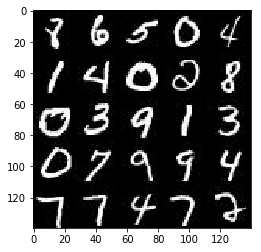

In [116]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

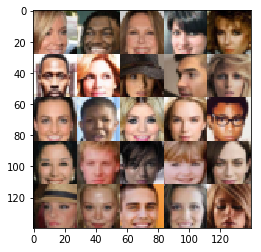

In [117]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [118]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.
  


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [119]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    input_z = tf.placeholder(tf.float32,(None,z_dim),name='z_dim')
    learning_rate = tf.placeholder(tf.float32)

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [120]:
def discriminator(images, reuse=False,alpha=0.01):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse=reuse):
        x1 = tf.layers.conv2d(images,64,5,strides=2,padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        relu1 = tf.maximum(alpha * x1,x1)
        relu1 = tf.nn.dropout(relu1,keep_prob=0.7)
        x2 = tf.layers.conv2d(relu1,128,5,strides=2,padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        
        bn2 = tf.layers.batch_normalization(x2,training=True)
        relu2 = tf.maximum(alpha * bn2,bn2)
        relu2 = tf.nn.dropout(relu2,keep_prob=0.7)
        
        x3 = tf.layers.conv2d(relu2,256,2,strides=2,padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        bn3 = tf.layers.batch_normalization(x3,training=True)
        relu3 = tf.maximum(alpha * bn3,bn3)
        relu3 = tf.nn.dropout(relu3,keep_prob=0.7)
        flat = tf.reshape(relu3,(-1,4*4*256))
        logits = tf.layers.dense(flat,1)
        out = tf.sigmoid(logits)

    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [121]:
def generator(z, out_channel_dim, is_train=True,alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse = not is_train):
        x1 = tf.layers.dense(z,4*4*512)
        x1 = tf.reshape(x1,(-1,4,4,512))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(alpha * x1,x1)
        
        x2 = tf.layers.conv2d_transpose(x1,256,5,strides=2,padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2,training=is_train)
        x2 = tf.maximum(alpha * x2,x2)
        x2 = tf.nn.dropout(x2,keep_prob=0.7)

        x3 = tf.layers.conv2d_transpose(x2,128,5,strides=2,padding='valid',
                                       kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3,training=is_train)
        x3 = tf.maximum(alpha * x3,x3)
        x3 = tf.nn.dropout(x3,keep_prob=0.7)
        
        logits = tf.layers.conv2d_transpose(x3,out_channel_dim,4,strides=1,padding='valid',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer())
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [122]:
def model_loss(input_real, input_z, out_channel_dim,smooth =0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real,reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1-smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)* (1-smooth))) 

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [123]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [124]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [125]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real,input_z,learning_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps =0
    show_every = 100
    print_every = 10
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps +=1
                batch_z = np.random.uniform(-1,1,size=(batch_size,z_dim))
                batch_images = batch_images * 2.0
                _ = sess.run(d_train_opt,feed_dict={input_real:batch_images,input_z:batch_z,learning_rate:0.001})
                _ = sess.run(g_train_opt,feed_dict={input_z:batch_z,input_real:batch_images,learning_rate:0.001})
                
                if steps % show_every == 0:
                    n_images = 16
                    show_generator_output(sess, n_images, input_z, data_shape[3], data_image_mode)
                    
                if steps % print_every ==0:
                    train_loss_d = d_loss.eval({input_z:batch_z,input_real:batch_images})
                    train_loss_g = g_loss.eval({input_z:batch_z,input_real:batch_images})
                
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                      "Discriminator Loss: {:.4f}...".format(train_loss_d),
                      "Generator Loss: {:.4f}".format(train_loss_g))
             

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Epoch 1/2... Discriminator Loss: 0.5088... Generator Loss: 2.9436
Epoch 1/2... Discriminator Loss: 0.4228... Generator Loss: 4.0612
Epoch 1/2... Discriminator Loss: 0.4172... Generator Loss: 5.1057
Epoch 1/2... Discriminator Loss: 0.3733... Generator Loss: 5.1061
Epoch 1/2... Discriminator Loss: 0.3785... Generator Loss: 5.7107
Epoch 1/2... Discriminator Loss: 0.3831... Generator Loss: 5.1305
Epoch 1/2... Discriminator Loss: 0.3535... Generator Loss: 6.1513
Epoch 1/2... Discriminator Loss: 0.3652... Generator Loss: 6.4847
Epoch 1/2... Discriminator Loss: 0.3623... Generator Loss: 5.9580


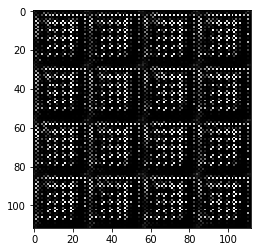

Epoch 1/2... Discriminator Loss: 0.3575... Generator Loss: 6.5485
Epoch 1/2... Discriminator Loss: 0.3514... Generator Loss: 6.8460
Epoch 1/2... Discriminator Loss: 0.3431... Generator Loss: 7.0683
Epoch 1/2... Discriminator Loss: 2.3425... Generator Loss: 14.7803
Epoch 1/2... Discriminator Loss: 0.3769... Generator Loss: 9.6802
Epoch 1/2... Discriminator Loss: 0.3596... Generator Loss: 9.0644
Epoch 1/2... Discriminator Loss: 0.3413... Generator Loss: 8.8602
Epoch 1/2... Discriminator Loss: 0.3461... Generator Loss: 8.7472
Epoch 1/2... Discriminator Loss: 0.3454... Generator Loss: 8.5368
Epoch 1/2... Discriminator Loss: 0.3427... Generator Loss: 8.4910


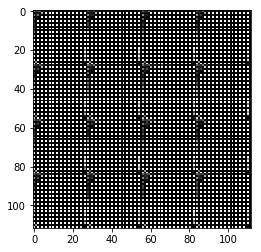

Epoch 1/2... Discriminator Loss: 0.3442... Generator Loss: 8.4623
Epoch 1/2... Discriminator Loss: 0.3480... Generator Loss: 5.9141
Epoch 1/2... Discriminator Loss: 0.3728... Generator Loss: 9.1792
Epoch 1/2... Discriminator Loss: 2.1508... Generator Loss: 13.5373
Epoch 1/2... Discriminator Loss: 0.3599... Generator Loss: 4.3492
Epoch 1/2... Discriminator Loss: 1.3186... Generator Loss: 3.8112
Epoch 1/2... Discriminator Loss: 0.5107... Generator Loss: 2.3900
Epoch 1/2... Discriminator Loss: 0.5266... Generator Loss: 2.6205
Epoch 1/2... Discriminator Loss: 0.5098... Generator Loss: 2.5456
Epoch 1/2... Discriminator Loss: 0.9750... Generator Loss: 4.1068


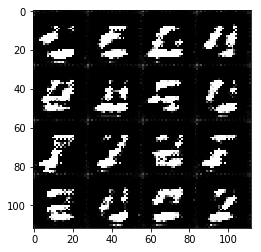

Epoch 1/2... Discriminator Loss: 0.7255... Generator Loss: 2.1478
Epoch 1/2... Discriminator Loss: 0.8056... Generator Loss: 3.2890
Epoch 1/2... Discriminator Loss: 0.9105... Generator Loss: 1.4300
Epoch 1/2... Discriminator Loss: 0.7566... Generator Loss: 1.5421
Epoch 1/2... Discriminator Loss: 0.7889... Generator Loss: 4.1619
Epoch 1/2... Discriminator Loss: 1.0591... Generator Loss: 1.3501
Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 2.5256
Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 3.0136
Epoch 1/2... Discriminator Loss: 1.4803... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 0.5736... Generator Loss: 2.2289


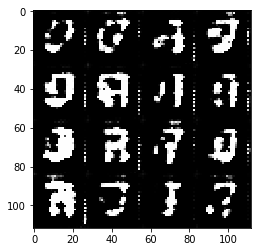

Epoch 1/2... Discriminator Loss: 0.6270... Generator Loss: 2.5368
Epoch 1/2... Discriminator Loss: 0.5748... Generator Loss: 2.7633
Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 1.8356
Epoch 1/2... Discriminator Loss: 1.9044... Generator Loss: 0.4843
Epoch 1/2... Discriminator Loss: 0.6651... Generator Loss: 2.0770
Epoch 1/2... Discriminator Loss: 1.8593... Generator Loss: 0.4562
Epoch 1/2... Discriminator Loss: 0.7471... Generator Loss: 1.8385
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 1.3141
Epoch 1/2... Discriminator Loss: 2.6768... Generator Loss: 0.4426
Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 1.1203


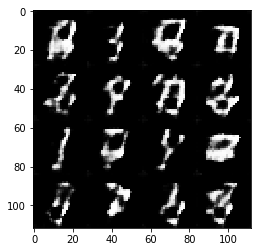

Epoch 1/2... Discriminator Loss: 1.6921... Generator Loss: 0.7012
Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 1.6260
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 1.0560
Epoch 1/2... Discriminator Loss: 1.2612... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 0.9330... Generator Loss: 1.7143
Epoch 1/2... Discriminator Loss: 0.8978... Generator Loss: 1.5001
Epoch 1/2... Discriminator Loss: 1.5491... Generator Loss: 0.6011
Epoch 1/2... Discriminator Loss: 1.1328... Generator Loss: 1.4157
Epoch 1/2... Discriminator Loss: 0.9780... Generator Loss: 1.5021
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.9065


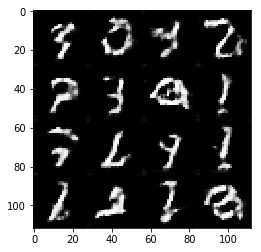

Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 0.9440
Epoch 1/2... Discriminator Loss: 1.0295... Generator Loss: 1.3460
Epoch 1/2... Discriminator Loss: 1.2498... Generator Loss: 1.4351
Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 0.9393
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 0.9492
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 1.5734
Epoch 1/2... Discriminator Loss: 1.1514... Generator Loss: 1.0462
Epoch 1/2... Discriminator Loss: 1.0561... Generator Loss: 1.4157
Epoch 1/2... Discriminator Loss: 1.2240... Generator Loss: 0.9123
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.9093


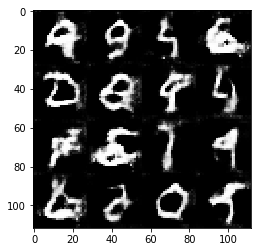

Epoch 1/2... Discriminator Loss: 1.1983... Generator Loss: 0.7563
Epoch 1/2... Discriminator Loss: 1.1098... Generator Loss: 1.0671
Epoch 1/2... Discriminator Loss: 1.3365... Generator Loss: 1.3824
Epoch 1/2... Discriminator Loss: 1.2262... Generator Loss: 1.3792
Epoch 1/2... Discriminator Loss: 1.2951... Generator Loss: 0.8538
Epoch 1/2... Discriminator Loss: 1.3212... Generator Loss: 0.6882
Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.7688
Epoch 1/2... Discriminator Loss: 1.3876... Generator Loss: 1.8308
Epoch 1/2... Discriminator Loss: 1.1963... Generator Loss: 0.8801
Epoch 1/2... Discriminator Loss: 1.0160... Generator Loss: 0.9769


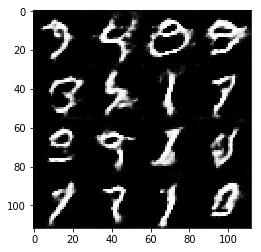

Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 1.0028
Epoch 1/2... Discriminator Loss: 1.3562... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 1.1880... Generator Loss: 1.4332
Epoch 1/2... Discriminator Loss: 1.4779... Generator Loss: 1.8410
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 0.8981
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 0.9087
Epoch 1/2... Discriminator Loss: 1.0889... Generator Loss: 0.9143
Epoch 1/2... Discriminator Loss: 1.3119... Generator Loss: 0.8404
Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 1.1089
Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 0.8909


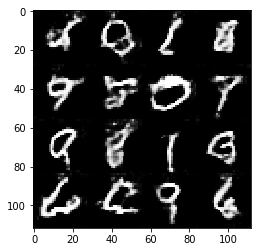

Epoch 1/2... Discriminator Loss: 1.7772... Generator Loss: 0.5000
Epoch 1/2... Discriminator Loss: 1.2322... Generator Loss: 0.8687
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 1.0051
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 1.1493
Epoch 2/2... Discriminator Loss: 1.2394... Generator Loss: 1.4155
Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 1.1351
Epoch 2/2... Discriminator Loss: 1.1394... Generator Loss: 0.9430
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 1.6765
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 0.8238
Epoch 2/2... Discriminator Loss: 1.4546... Generator Loss: 1.7443


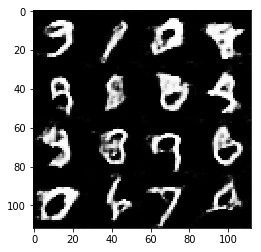

Epoch 2/2... Discriminator Loss: 1.3222... Generator Loss: 0.7374
Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.8862
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 1.0257
Epoch 2/2... Discriminator Loss: 1.2639... Generator Loss: 0.7684
Epoch 2/2... Discriminator Loss: 1.0206... Generator Loss: 1.1086
Epoch 2/2... Discriminator Loss: 1.3451... Generator Loss: 0.8166
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 1.1053
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.0049
Epoch 2/2... Discriminator Loss: 1.2292... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 1.4073... Generator Loss: 0.7073


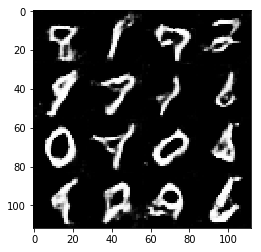

Epoch 2/2... Discriminator Loss: 1.1943... Generator Loss: 0.9848
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 1.1692... Generator Loss: 1.0336
Epoch 2/2... Discriminator Loss: 1.0820... Generator Loss: 1.1457
Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 1.5202
Epoch 2/2... Discriminator Loss: 1.1089... Generator Loss: 1.0976
Epoch 2/2... Discriminator Loss: 1.1445... Generator Loss: 0.9123
Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 1.4362
Epoch 2/2... Discriminator Loss: 1.2256... Generator Loss: 0.7158
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 0.8991


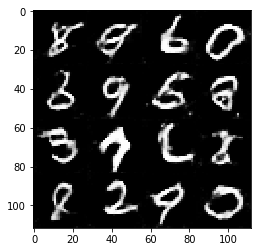

Epoch 2/2... Discriminator Loss: 1.1373... Generator Loss: 1.1947
Epoch 2/2... Discriminator Loss: 1.2432... Generator Loss: 1.0152
Epoch 2/2... Discriminator Loss: 1.2867... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.1655... Generator Loss: 0.9119
Epoch 2/2... Discriminator Loss: 1.2043... Generator Loss: 0.7723
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 1.2100
Epoch 2/2... Discriminator Loss: 1.1723... Generator Loss: 0.8189
Epoch 2/2... Discriminator Loss: 1.0688... Generator Loss: 1.1684
Epoch 2/2... Discriminator Loss: 1.1541... Generator Loss: 0.9351
Epoch 2/2... Discriminator Loss: 1.1481... Generator Loss: 1.4085


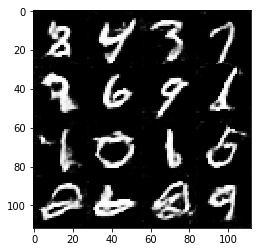

Epoch 2/2... Discriminator Loss: 1.0685... Generator Loss: 1.2240
Epoch 2/2... Discriminator Loss: 1.1768... Generator Loss: 1.3447
Epoch 2/2... Discriminator Loss: 1.2227... Generator Loss: 0.7319
Epoch 2/2... Discriminator Loss: 1.3457... Generator Loss: 0.6760
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.6860
Epoch 2/2... Discriminator Loss: 1.1028... Generator Loss: 0.9612
Epoch 2/2... Discriminator Loss: 1.0661... Generator Loss: 1.1116
Epoch 2/2... Discriminator Loss: 1.1709... Generator Loss: 0.6881
Epoch 2/2... Discriminator Loss: 1.0869... Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 1.8444... Generator Loss: 2.7313


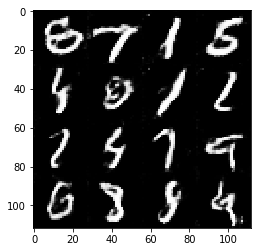

Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 1.0247
Epoch 2/2... Discriminator Loss: 1.0555... Generator Loss: 1.2837
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.9678
Epoch 2/2... Discriminator Loss: 1.3079... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.3489... Generator Loss: 0.8027
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 0.8871
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.9601
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 1.2892
Epoch 2/2... Discriminator Loss: 1.3072... Generator Loss: 0.7662
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 0.8438


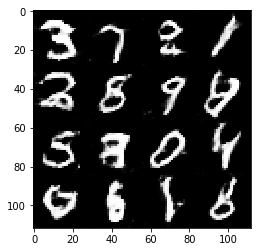

Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 1.5505
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 1.0279
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 1.1748
Epoch 2/2... Discriminator Loss: 1.3315... Generator Loss: 0.8623
Epoch 2/2... Discriminator Loss: 1.3765... Generator Loss: 0.7031
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 0.9023
Epoch 2/2... Discriminator Loss: 1.1295... Generator Loss: 1.0455
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 1.3174
Epoch 2/2... Discriminator Loss: 1.3471... Generator Loss: 0.7345
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 1.3781


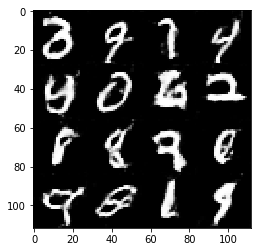

Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 1.1223
Epoch 2/2... Discriminator Loss: 1.4544... Generator Loss: 0.5755
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.9377
Epoch 2/2... Discriminator Loss: 1.1353... Generator Loss: 1.2259
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 1.0727
Epoch 2/2... Discriminator Loss: 1.1890... Generator Loss: 0.9977
Epoch 2/2... Discriminator Loss: 1.2360... Generator Loss: 1.0092
Epoch 2/2... Discriminator Loss: 1.2137... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.8908
Epoch 2/2... Discriminator Loss: 1.0701... Generator Loss: 0.9866


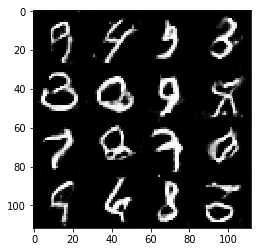

Epoch 2/2... Discriminator Loss: 1.2105... Generator Loss: 1.1918
Epoch 2/2... Discriminator Loss: 1.1146... Generator Loss: 1.4244
Epoch 2/2... Discriminator Loss: 1.2679... Generator Loss: 0.9032
Epoch 2/2... Discriminator Loss: 1.1243... Generator Loss: 0.8179
Epoch 2/2... Discriminator Loss: 1.3255... Generator Loss: 0.8596
Epoch 2/2... Discriminator Loss: 1.0605... Generator Loss: 1.3434
Epoch 2/2... Discriminator Loss: 1.3077... Generator Loss: 1.3314
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 0.8644
Epoch 2/2... Discriminator Loss: 1.2261... Generator Loss: 1.2630
Epoch 2/2... Discriminator Loss: 1.7538... Generator Loss: 0.5277


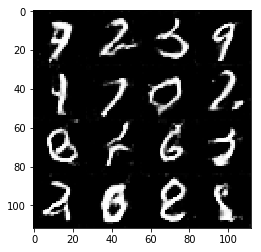

Epoch 2/2... Discriminator Loss: 1.2351... Generator Loss: 1.3736
Epoch 2/2... Discriminator Loss: 1.1783... Generator Loss: 0.8194
Epoch 2/2... Discriminator Loss: 1.7201... Generator Loss: 0.5473
Epoch 2/2... Discriminator Loss: 1.2746... Generator Loss: 0.9427
Epoch 2/2... Discriminator Loss: 1.3098... Generator Loss: 0.9278
Epoch 2/2... Discriminator Loss: 1.2008... Generator Loss: 1.5468
Epoch 2/2... Discriminator Loss: 1.0303... Generator Loss: 0.8914
Epoch 2/2... Discriminator Loss: 1.6362... Generator Loss: 0.5474


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 0.9803
Epoch 1/2... Discriminator Loss: 0.4912... Generator Loss: 3.9466
Epoch 1/2... Discriminator Loss: 1.2687... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 0.4342... Generator Loss: 6.2466
Epoch 1/2... Discriminator Loss: 0.4251... Generator Loss: 3.9699
Epoch 1/2... Discriminator Loss: 1.0054... Generator Loss: 1.7808
Epoch 1/2... Discriminator Loss: 0.6559... Generator Loss: 2.4790
Epoch 1/2... Discriminator Loss: 0.4642... Generator Loss: 5.0446
Epoch 1/2... Discriminator Loss: 0.5823... Generator Loss: 2.9159


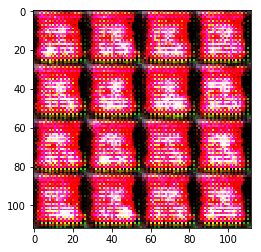

Epoch 1/2... Discriminator Loss: 0.5029... Generator Loss: 3.7149
Epoch 1/2... Discriminator Loss: 2.1988... Generator Loss: 0.4171
Epoch 1/2... Discriminator Loss: 0.5352... Generator Loss: 7.0433
Epoch 1/2... Discriminator Loss: 0.4828... Generator Loss: 3.5405
Epoch 1/2... Discriminator Loss: 0.4517... Generator Loss: 3.6034
Epoch 1/2... Discriminator Loss: 0.3908... Generator Loss: 3.4037
Epoch 1/2... Discriminator Loss: 0.4233... Generator Loss: 2.9263
Epoch 1/2... Discriminator Loss: 0.4175... Generator Loss: 3.8967
Epoch 1/2... Discriminator Loss: 0.4005... Generator Loss: 4.2077
Epoch 1/2... Discriminator Loss: 0.5226... Generator Loss: 3.0771


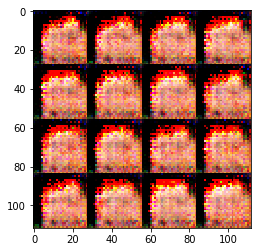

Epoch 1/2... Discriminator Loss: 0.4482... Generator Loss: 3.0874
Epoch 1/2... Discriminator Loss: 0.4036... Generator Loss: 4.1582
Epoch 1/2... Discriminator Loss: 0.5700... Generator Loss: 5.3358
Epoch 1/2... Discriminator Loss: 0.5794... Generator Loss: 2.3576
Epoch 1/2... Discriminator Loss: 0.5526... Generator Loss: 3.5459
Epoch 1/2... Discriminator Loss: 0.4425... Generator Loss: 3.8709
Epoch 1/2... Discriminator Loss: 0.4741... Generator Loss: 3.3458
Epoch 1/2... Discriminator Loss: 0.4200... Generator Loss: 3.5354
Epoch 1/2... Discriminator Loss: 0.5086... Generator Loss: 2.7913
Epoch 1/2... Discriminator Loss: 0.7449... Generator Loss: 1.3592


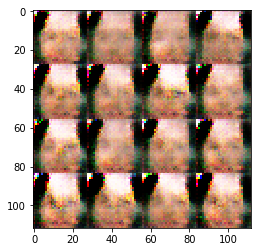

Epoch 1/2... Discriminator Loss: 0.4261... Generator Loss: 4.4140
Epoch 1/2... Discriminator Loss: 0.5269... Generator Loss: 3.3774
Epoch 1/2... Discriminator Loss: 0.5992... Generator Loss: 2.2398
Epoch 1/2... Discriminator Loss: 0.6334... Generator Loss: 2.1942
Epoch 1/2... Discriminator Loss: 0.4184... Generator Loss: 3.4926
Epoch 1/2... Discriminator Loss: 0.6044... Generator Loss: 1.8165
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 0.8208
Epoch 1/2... Discriminator Loss: 0.9043... Generator Loss: 1.6656
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 1.9493
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 4.3531


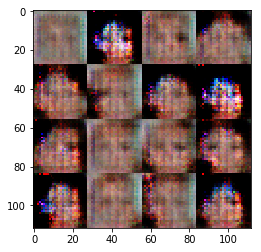

Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 1.5004
Epoch 1/2... Discriminator Loss: 1.5095... Generator Loss: 0.6740
Epoch 1/2... Discriminator Loss: 0.8456... Generator Loss: 2.6411
Epoch 1/2... Discriminator Loss: 0.9273... Generator Loss: 1.4896
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 1.4580
Epoch 1/2... Discriminator Loss: 2.0642... Generator Loss: 5.4398
Epoch 1/2... Discriminator Loss: 0.7417... Generator Loss: 1.9730
Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 1.0955
Epoch 1/2... Discriminator Loss: 0.7974... Generator Loss: 1.7320
Epoch 1/2... Discriminator Loss: 1.3891... Generator Loss: 0.7173


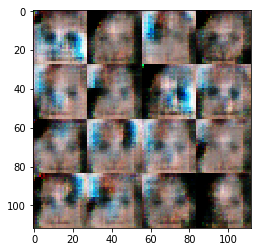

Epoch 1/2... Discriminator Loss: 1.2458... Generator Loss: 1.6488
Epoch 1/2... Discriminator Loss: 0.9683... Generator Loss: 1.8693
Epoch 1/2... Discriminator Loss: 0.9905... Generator Loss: 2.4820
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 1.2826
Epoch 1/2... Discriminator Loss: 0.8940... Generator Loss: 1.6544
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 2.0651
Epoch 1/2... Discriminator Loss: 1.0772... Generator Loss: 1.5055
Epoch 1/2... Discriminator Loss: 1.0898... Generator Loss: 1.3496
Epoch 1/2... Discriminator Loss: 1.0455... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 0.8515... Generator Loss: 1.2644


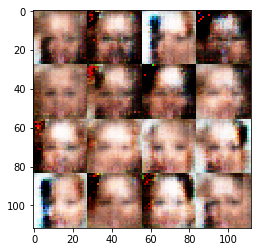

Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 1.0625
Epoch 1/2... Discriminator Loss: 1.1600... Generator Loss: 1.1353
Epoch 1/2... Discriminator Loss: 0.6978... Generator Loss: 1.9116
Epoch 1/2... Discriminator Loss: 0.8951... Generator Loss: 1.5036
Epoch 1/2... Discriminator Loss: 1.5330... Generator Loss: 0.7482
Epoch 1/2... Discriminator Loss: 0.8454... Generator Loss: 1.8857
Epoch 1/2... Discriminator Loss: 1.1764... Generator Loss: 0.9634
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 0.9547
Epoch 1/2... Discriminator Loss: 1.0323... Generator Loss: 1.6144
Epoch 1/2... Discriminator Loss: 1.0516... Generator Loss: 1.3684


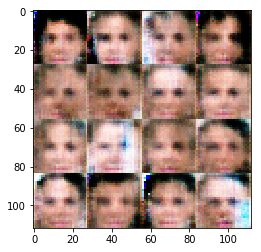

Epoch 1/2... Discriminator Loss: 1.2138... Generator Loss: 0.9374
Epoch 1/2... Discriminator Loss: 0.8325... Generator Loss: 1.6245
Epoch 1/2... Discriminator Loss: 1.5853... Generator Loss: 1.6465
Epoch 1/2... Discriminator Loss: 0.9377... Generator Loss: 1.0611
Epoch 1/2... Discriminator Loss: 1.2243... Generator Loss: 2.0648
Epoch 1/2... Discriminator Loss: 1.6759... Generator Loss: 0.6821
Epoch 1/2... Discriminator Loss: 0.9099... Generator Loss: 1.6480
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 2.2116
Epoch 1/2... Discriminator Loss: 0.9924... Generator Loss: 1.7914
Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 1.6404


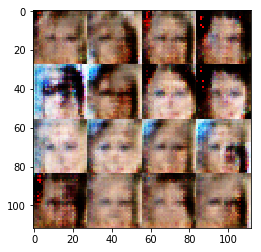

Epoch 1/2... Discriminator Loss: 0.7277... Generator Loss: 1.6454
Epoch 1/2... Discriminator Loss: 1.1020... Generator Loss: 0.9876
Epoch 1/2... Discriminator Loss: 0.9780... Generator Loss: 1.2318
Epoch 1/2... Discriminator Loss: 0.8884... Generator Loss: 1.6319
Epoch 1/2... Discriminator Loss: 0.9080... Generator Loss: 1.3286
Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 1.0111
Epoch 1/2... Discriminator Loss: 0.7286... Generator Loss: 1.2946
Epoch 1/2... Discriminator Loss: 1.1215... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 0.8924
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 1.1554


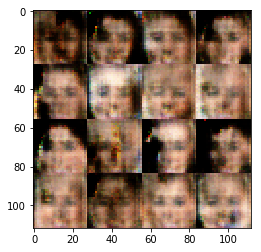

Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 2.0115
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.6057
Epoch 1/2... Discriminator Loss: 0.8049... Generator Loss: 1.8157
Epoch 1/2... Discriminator Loss: 1.2132... Generator Loss: 1.0056
Epoch 1/2... Discriminator Loss: 0.9901... Generator Loss: 1.6740
Epoch 1/2... Discriminator Loss: 0.7357... Generator Loss: 2.1693
Epoch 1/2... Discriminator Loss: 1.0995... Generator Loss: 3.4495
Epoch 1/2... Discriminator Loss: 1.0555... Generator Loss: 0.7824
Epoch 1/2... Discriminator Loss: 1.0044... Generator Loss: 1.2315
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.6542


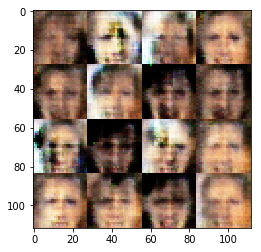

Epoch 1/2... Discriminator Loss: 0.7731... Generator Loss: 1.4310
Epoch 1/2... Discriminator Loss: 1.7243... Generator Loss: 0.4938
Epoch 1/2... Discriminator Loss: 1.3397... Generator Loss: 2.7390
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 1.4745
Epoch 1/2... Discriminator Loss: 0.7415... Generator Loss: 1.9333
Epoch 1/2... Discriminator Loss: 0.8610... Generator Loss: 1.5486
Epoch 1/2... Discriminator Loss: 0.8684... Generator Loss: 2.1863
Epoch 1/2... Discriminator Loss: 1.0505... Generator Loss: 2.1661
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 1.6355
Epoch 1/2... Discriminator Loss: 1.1632... Generator Loss: 1.1721


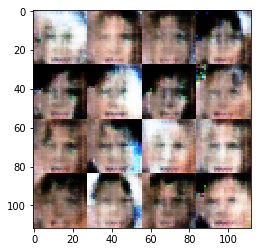

Epoch 1/2... Discriminator Loss: 2.0057... Generator Loss: 0.4273
Epoch 1/2... Discriminator Loss: 1.0406... Generator Loss: 2.2199
Epoch 1/2... Discriminator Loss: 0.8632... Generator Loss: 1.6175
Epoch 1/2... Discriminator Loss: 0.9007... Generator Loss: 1.2253
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 1.0884
Epoch 1/2... Discriminator Loss: 1.2184... Generator Loss: 2.1369
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 1.1211
Epoch 1/2... Discriminator Loss: 0.8183... Generator Loss: 1.0346
Epoch 1/2... Discriminator Loss: 1.0422... Generator Loss: 1.2301
Epoch 1/2... Discriminator Loss: 1.2582... Generator Loss: 0.9574


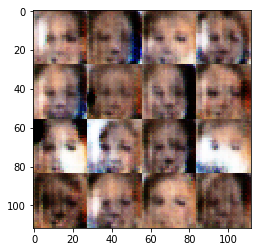

Epoch 1/2... Discriminator Loss: 0.8064... Generator Loss: 1.3554
Epoch 1/2... Discriminator Loss: 0.9843... Generator Loss: 1.9417
Epoch 1/2... Discriminator Loss: 0.8291... Generator Loss: 1.6718
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 1.0003
Epoch 1/2... Discriminator Loss: 1.4598... Generator Loss: 0.5424
Epoch 1/2... Discriminator Loss: 1.1140... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 0.9688... Generator Loss: 1.0831
Epoch 1/2... Discriminator Loss: 0.8480... Generator Loss: 1.5653
Epoch 1/2... Discriminator Loss: 0.8901... Generator Loss: 1.2938
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 0.8392


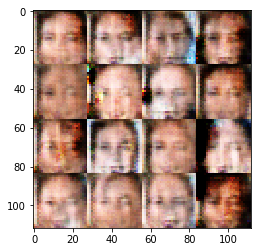

Epoch 1/2... Discriminator Loss: 0.8465... Generator Loss: 1.3202
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 1.3264
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 1.3870
Epoch 1/2... Discriminator Loss: 1.2532... Generator Loss: 1.8845
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 0.9013
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 0.9724... Generator Loss: 1.6836
Epoch 1/2... Discriminator Loss: 0.8996... Generator Loss: 1.6647
Epoch 1/2... Discriminator Loss: 0.8028... Generator Loss: 1.6199
Epoch 1/2... Discriminator Loss: 0.6751... Generator Loss: 1.3664


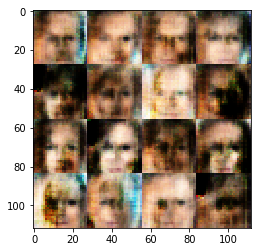

Epoch 1/2... Discriminator Loss: 1.0819... Generator Loss: 1.3528
Epoch 1/2... Discriminator Loss: 1.1660... Generator Loss: 2.0256
Epoch 1/2... Discriminator Loss: 0.8261... Generator Loss: 1.5517
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 1.1315
Epoch 1/2... Discriminator Loss: 0.8708... Generator Loss: 1.1966
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 0.9669
Epoch 1/2... Discriminator Loss: 0.9912... Generator Loss: 0.7334
Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 1.3226
Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.8583
Epoch 1/2... Discriminator Loss: 0.8379... Generator Loss: 1.4035


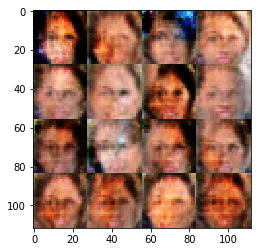

Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 1.2545
Epoch 1/2... Discriminator Loss: 1.3812... Generator Loss: 1.0513
Epoch 1/2... Discriminator Loss: 0.9243... Generator Loss: 0.8863
Epoch 1/2... Discriminator Loss: 1.5171... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 0.9091... Generator Loss: 1.7252
Epoch 1/2... Discriminator Loss: 0.9780... Generator Loss: 0.9931
Epoch 1/2... Discriminator Loss: 1.1942... Generator Loss: 1.3522
Epoch 1/2... Discriminator Loss: 1.6381... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.0594... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.8518


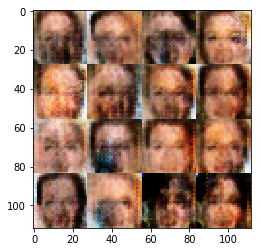

Epoch 1/2... Discriminator Loss: 0.7771... Generator Loss: 1.3009
Epoch 1/2... Discriminator Loss: 0.9677... Generator Loss: 0.8971
Epoch 1/2... Discriminator Loss: 1.6220... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 1.6160... Generator Loss: 0.5520
Epoch 1/2... Discriminator Loss: 0.9395... Generator Loss: 1.3968
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 1.0632
Epoch 1/2... Discriminator Loss: 0.9547... Generator Loss: 1.2444
Epoch 1/2... Discriminator Loss: 1.3070... Generator Loss: 1.0284
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 1.2457
Epoch 1/2... Discriminator Loss: 1.0260... Generator Loss: 0.8049


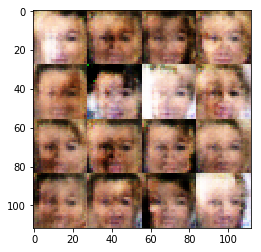

Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 1.0145
Epoch 1/2... Discriminator Loss: 1.0194... Generator Loss: 0.8285
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 1.3291
Epoch 1/2... Discriminator Loss: 1.9023... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 1.8568
Epoch 1/2... Discriminator Loss: 1.2282... Generator Loss: 0.7300
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 1.5232
Epoch 1/2... Discriminator Loss: 0.6899... Generator Loss: 2.1533
Epoch 1/2... Discriminator Loss: 1.0574... Generator Loss: 0.7951
Epoch 1/2... Discriminator Loss: 1.2553... Generator Loss: 0.9845


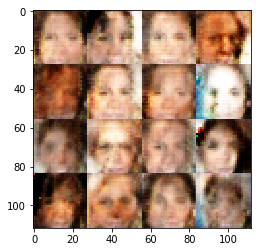

Epoch 1/2... Discriminator Loss: 1.9541... Generator Loss: 0.4730
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 1.0799
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 1.2542
Epoch 1/2... Discriminator Loss: 1.2991... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 1.1112... Generator Loss: 1.0319
Epoch 1/2... Discriminator Loss: 0.9549... Generator Loss: 1.2590
Epoch 1/2... Discriminator Loss: 2.2427... Generator Loss: 0.4146
Epoch 1/2... Discriminator Loss: 1.1015... Generator Loss: 1.0840
Epoch 1/2... Discriminator Loss: 1.6686... Generator Loss: 1.8517
Epoch 1/2... Discriminator Loss: 1.3341... Generator Loss: 0.6924


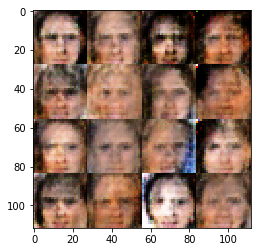

Epoch 1/2... Discriminator Loss: 2.1644... Generator Loss: 2.0268
Epoch 1/2... Discriminator Loss: 1.3677... Generator Loss: 2.0747
Epoch 1/2... Discriminator Loss: 0.9553... Generator Loss: 1.8258
Epoch 1/2... Discriminator Loss: 1.3192... Generator Loss: 0.9005
Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 1.1005
Epoch 1/2... Discriminator Loss: 1.0963... Generator Loss: 1.1417
Epoch 1/2... Discriminator Loss: 1.4057... Generator Loss: 0.6577
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 1.7155
Epoch 1/2... Discriminator Loss: 1.0919... Generator Loss: 1.3076
Epoch 1/2... Discriminator Loss: 0.9180... Generator Loss: 0.9555


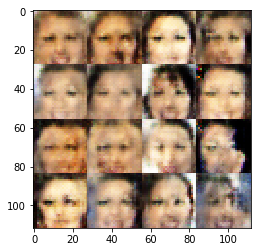

Epoch 1/2... Discriminator Loss: 1.2656... Generator Loss: 1.0924
Epoch 1/2... Discriminator Loss: 1.7480... Generator Loss: 0.6673
Epoch 1/2... Discriminator Loss: 1.3314... Generator Loss: 0.9567
Epoch 1/2... Discriminator Loss: 1.1429... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.8364
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 1.3408
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 1.1612
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 1.1642
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.1789... Generator Loss: 1.0196


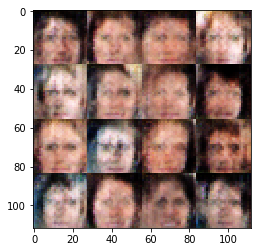

Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 0.7882
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 1.3089
Epoch 1/2... Discriminator Loss: 1.5544... Generator Loss: 0.5409
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 1.2035... Generator Loss: 1.0591
Epoch 1/2... Discriminator Loss: 1.1700... Generator Loss: 1.1269
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.9228
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.9865
Epoch 1/2... Discriminator Loss: 1.7143... Generator Loss: 0.6857


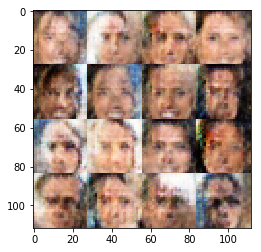

Epoch 1/2... Discriminator Loss: 1.1319... Generator Loss: 1.0354
Epoch 1/2... Discriminator Loss: 1.0496... Generator Loss: 1.0695
Epoch 1/2... Discriminator Loss: 1.2826... Generator Loss: 1.0205
Epoch 1/2... Discriminator Loss: 0.9775... Generator Loss: 1.2404
Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.8267
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 1.0977
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.2324... Generator Loss: 0.9693
Epoch 1/2... Discriminator Loss: 1.2303... Generator Loss: 0.8005
Epoch 1/2... Discriminator Loss: 1.1125... Generator Loss: 0.9955


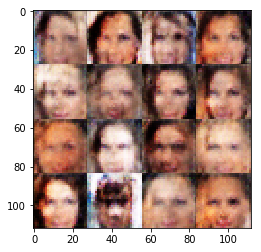

Epoch 1/2... Discriminator Loss: 1.4227... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.0537... Generator Loss: 1.3447
Epoch 1/2... Discriminator Loss: 1.0934... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 1.7952... Generator Loss: 0.8732
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 1.0686... Generator Loss: 1.0763
Epoch 1/2... Discriminator Loss: 1.3716... Generator Loss: 1.2977
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 1.5292... Generator Loss: 0.7566
Epoch 1/2... Discriminator Loss: 1.2039... Generator Loss: 1.1119


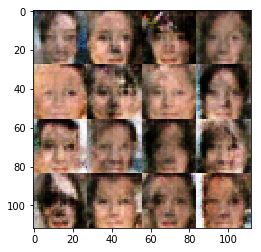

Epoch 1/2... Discriminator Loss: 1.2293... Generator Loss: 1.3473
Epoch 1/2... Discriminator Loss: 1.3144... Generator Loss: 0.8560
Epoch 1/2... Discriminator Loss: 1.3720... Generator Loss: 0.9652
Epoch 1/2... Discriminator Loss: 1.4937... Generator Loss: 0.9991
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 0.9258
Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 1.1175
Epoch 1/2... Discriminator Loss: 1.4054... Generator Loss: 0.7486
Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 0.8701
Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 1.1771
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 0.9470


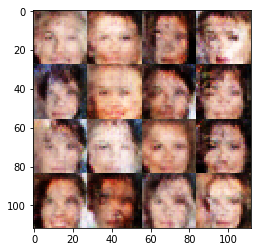

Epoch 1/2... Discriminator Loss: 1.3797... Generator Loss: 1.0502
Epoch 1/2... Discriminator Loss: 1.0830... Generator Loss: 1.2079
Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 1.3029
Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 1.4744
Epoch 1/2... Discriminator Loss: 1.3835... Generator Loss: 0.7309
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 1.0584
Epoch 1/2... Discriminator Loss: 1.4563... Generator Loss: 0.9590
Epoch 1/2... Discriminator Loss: 1.3202... Generator Loss: 0.8494
Epoch 1/2... Discriminator Loss: 1.0158... Generator Loss: 1.1717
Epoch 1/2... Discriminator Loss: 1.2890... Generator Loss: 1.0093


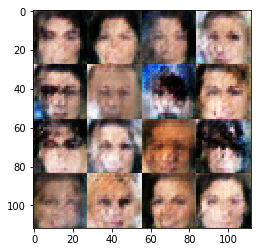

Epoch 1/2... Discriminator Loss: 1.0585... Generator Loss: 1.2265
Epoch 1/2... Discriminator Loss: 1.1579... Generator Loss: 1.1028
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.8509
Epoch 1/2... Discriminator Loss: 1.0540... Generator Loss: 1.1342
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 1.3625
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 1.1732
Epoch 1/2... Discriminator Loss: 1.2013... Generator Loss: 0.9481
Epoch 1/2... Discriminator Loss: 1.0218... Generator Loss: 1.0668
Epoch 1/2... Discriminator Loss: 1.3205... Generator Loss: 0.8017
Epoch 1/2... Discriminator Loss: 1.2347... Generator Loss: 1.1731


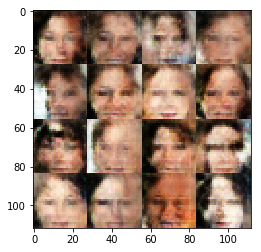

Epoch 1/2... Discriminator Loss: 1.3279... Generator Loss: 1.0523
Epoch 1/2... Discriminator Loss: 1.2118... Generator Loss: 1.5648
Epoch 1/2... Discriminator Loss: 1.1856... Generator Loss: 1.2116
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 1.2668
Epoch 1/2... Discriminator Loss: 1.0885... Generator Loss: 1.4372
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 1.0074
Epoch 1/2... Discriminator Loss: 1.1786... Generator Loss: 1.2913
Epoch 1/2... Discriminator Loss: 1.4075... Generator Loss: 0.8437
Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 1.0718
Epoch 1/2... Discriminator Loss: 0.9354... Generator Loss: 1.0598


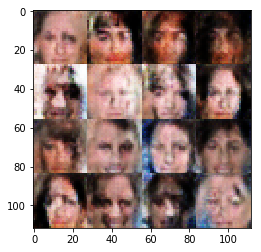

Epoch 1/2... Discriminator Loss: 1.1581... Generator Loss: 1.3802
Epoch 1/2... Discriminator Loss: 1.2985... Generator Loss: 0.8080
Epoch 1/2... Discriminator Loss: 0.9884... Generator Loss: 1.1989
Epoch 1/2... Discriminator Loss: 1.1798... Generator Loss: 1.1240
Epoch 1/2... Discriminator Loss: 1.2506... Generator Loss: 1.0439
Epoch 1/2... Discriminator Loss: 1.1665... Generator Loss: 1.1014
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.9266
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 1.0170
Epoch 1/2... Discriminator Loss: 1.1582... Generator Loss: 0.8833
Epoch 1/2... Discriminator Loss: 1.1772... Generator Loss: 1.2538


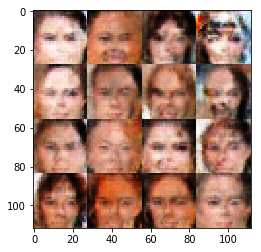

Epoch 1/2... Discriminator Loss: 1.3268... Generator Loss: 1.1230
Epoch 1/2... Discriminator Loss: 1.2210... Generator Loss: 0.8857
Epoch 1/2... Discriminator Loss: 1.0802... Generator Loss: 1.1210
Epoch 1/2... Discriminator Loss: 1.3170... Generator Loss: 1.0875
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.8817
Epoch 1/2... Discriminator Loss: 1.2270... Generator Loss: 1.0444
Epoch 1/2... Discriminator Loss: 1.1168... Generator Loss: 0.8731
Epoch 1/2... Discriminator Loss: 1.4886... Generator Loss: 1.1053
Epoch 1/2... Discriminator Loss: 0.9954... Generator Loss: 1.2175
Epoch 1/2... Discriminator Loss: 1.4262... Generator Loss: 0.8502


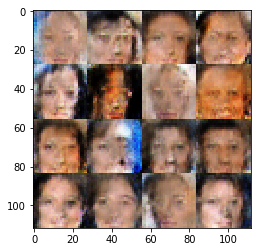

Epoch 1/2... Discriminator Loss: 1.3738... Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 1.1182... Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 1.0447
Epoch 1/2... Discriminator Loss: 1.2251... Generator Loss: 1.4189
Epoch 1/2... Discriminator Loss: 1.0714... Generator Loss: 1.0034
Epoch 1/2... Discriminator Loss: 1.3154... Generator Loss: 0.9480
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 0.9124
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 0.7557
Epoch 1/2... Discriminator Loss: 1.3999... Generator Loss: 0.9497
Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 1.1093


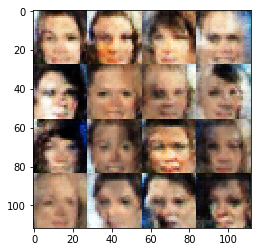

Epoch 1/2... Discriminator Loss: 1.3557... Generator Loss: 0.9070
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 1.0998
Epoch 1/2... Discriminator Loss: 1.1399... Generator Loss: 0.9285
Epoch 1/2... Discriminator Loss: 1.4218... Generator Loss: 1.0909
Epoch 1/2... Discriminator Loss: 1.2594... Generator Loss: 0.8311
Epoch 1/2... Discriminator Loss: 1.2111... Generator Loss: 1.1332
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.9571
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 1.3624
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 1.0310
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 1.1890


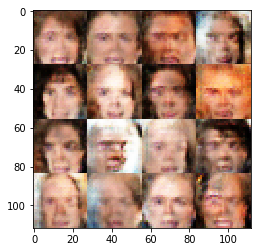

Epoch 1/2... Discriminator Loss: 1.2422... Generator Loss: 1.4531
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 1.5838
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.7810
Epoch 1/2... Discriminator Loss: 1.1987... Generator Loss: 1.2222
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 0.9846
Epoch 1/2... Discriminator Loss: 1.4336... Generator Loss: 1.1122
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.1086... Generator Loss: 1.0598
Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 0.9464
Epoch 1/2... Discriminator Loss: 0.9448... Generator Loss: 1.2204


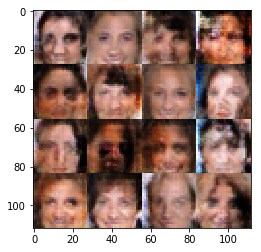

Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 0.9195
Epoch 1/2... Discriminator Loss: 1.0179... Generator Loss: 1.2371
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.8834
Epoch 1/2... Discriminator Loss: 1.0957... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 1.1532... Generator Loss: 0.8618
Epoch 1/2... Discriminator Loss: 1.2575... Generator Loss: 0.7595
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 0.9297
Epoch 1/2... Discriminator Loss: 1.0387... Generator Loss: 1.1090
Epoch 1/2... Discriminator Loss: 1.0704... Generator Loss: 1.0448
Epoch 1/2... Discriminator Loss: 1.0988... Generator Loss: 1.3069


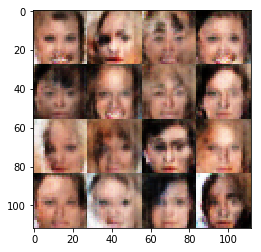

Epoch 1/2... Discriminator Loss: 1.0899... Generator Loss: 1.0875
Epoch 1/2... Discriminator Loss: 1.1819... Generator Loss: 0.9190
Epoch 1/2... Discriminator Loss: 1.4428... Generator Loss: 0.7362
Epoch 1/2... Discriminator Loss: 1.2226... Generator Loss: 1.0620
Epoch 1/2... Discriminator Loss: 1.4027... Generator Loss: 0.7116
Epoch 1/2... Discriminator Loss: 1.1728... Generator Loss: 1.1008
Epoch 1/2... Discriminator Loss: 0.9995... Generator Loss: 1.3105
Epoch 1/2... Discriminator Loss: 1.1835... Generator Loss: 1.2207
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.9078
Epoch 1/2... Discriminator Loss: 1.1158... Generator Loss: 1.2486


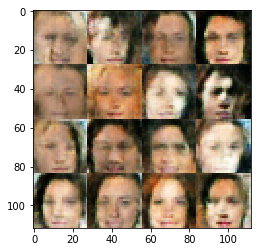

Epoch 1/2... Discriminator Loss: 1.1498... Generator Loss: 0.8529
Epoch 1/2... Discriminator Loss: 1.1609... Generator Loss: 0.9587
Epoch 1/2... Discriminator Loss: 1.1748... Generator Loss: 1.0704
Epoch 1/2... Discriminator Loss: 1.1082... Generator Loss: 1.0896
Epoch 1/2... Discriminator Loss: 1.1131... Generator Loss: 1.6077
Epoch 1/2... Discriminator Loss: 1.1656... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 1.0179
Epoch 1/2... Discriminator Loss: 1.1613... Generator Loss: 0.9314
Epoch 1/2... Discriminator Loss: 1.2825... Generator Loss: 0.9818
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.9854


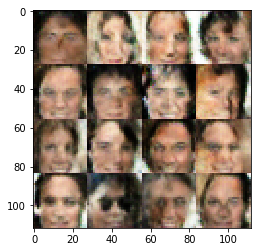

Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 1.0522
Epoch 1/2... Discriminator Loss: 1.0911... Generator Loss: 0.9671
Epoch 1/2... Discriminator Loss: 1.0757... Generator Loss: 1.1216
Epoch 1/2... Discriminator Loss: 0.9902... Generator Loss: 1.3235
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 0.8846
Epoch 1/2... Discriminator Loss: 1.1877... Generator Loss: 0.7718
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.9853
Epoch 1/2... Discriminator Loss: 1.3863... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.2288... Generator Loss: 0.8796
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 0.9901


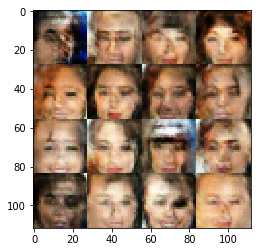

Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 1.4590
Epoch 1/2... Discriminator Loss: 1.3435... Generator Loss: 1.2354
Epoch 1/2... Discriminator Loss: 0.9569... Generator Loss: 1.1531
Epoch 1/2... Discriminator Loss: 1.2181... Generator Loss: 0.6606
Epoch 1/2... Discriminator Loss: 1.1773... Generator Loss: 1.0218
Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 0.9705
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 1.1566
Epoch 1/2... Discriminator Loss: 1.1640... Generator Loss: 0.7009
Epoch 1/2... Discriminator Loss: 1.0746... Generator Loss: 0.8120
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 1.2436


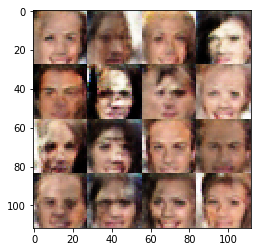

Epoch 1/2... Discriminator Loss: 1.1598... Generator Loss: 0.8658
Epoch 1/2... Discriminator Loss: 1.1859... Generator Loss: 1.3545
Epoch 1/2... Discriminator Loss: 1.1103... Generator Loss: 1.1941
Epoch 1/2... Discriminator Loss: 1.2045... Generator Loss: 0.7655
Epoch 1/2... Discriminator Loss: 1.1074... Generator Loss: 1.0944
Epoch 1/2... Discriminator Loss: 1.2946... Generator Loss: 0.8876
Epoch 1/2... Discriminator Loss: 1.1004... Generator Loss: 1.0703
Epoch 1/2... Discriminator Loss: 1.1820... Generator Loss: 1.2602
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.7941
Epoch 1/2... Discriminator Loss: 1.4527... Generator Loss: 0.8207


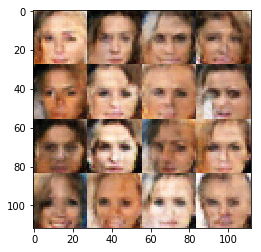

Epoch 1/2... Discriminator Loss: 1.1102... Generator Loss: 1.2886
Epoch 1/2... Discriminator Loss: 1.3656... Generator Loss: 0.9607
Epoch 1/2... Discriminator Loss: 1.3141... Generator Loss: 0.9848
Epoch 1/2... Discriminator Loss: 1.3980... Generator Loss: 0.8808
Epoch 1/2... Discriminator Loss: 1.1690... Generator Loss: 1.1508
Epoch 1/2... Discriminator Loss: 1.2937... Generator Loss: 1.3984
Epoch 1/2... Discriminator Loss: 1.1881... Generator Loss: 0.9422
Epoch 1/2... Discriminator Loss: 1.0931... Generator Loss: 1.1053
Epoch 1/2... Discriminator Loss: 1.3023... Generator Loss: 0.9030
Epoch 1/2... Discriminator Loss: 1.1088... Generator Loss: 1.1300


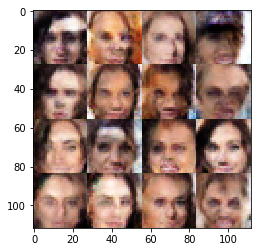

Epoch 1/2... Discriminator Loss: 1.2641... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.2348... Generator Loss: 1.2972
Epoch 1/2... Discriminator Loss: 1.3359... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 1.1935... Generator Loss: 0.9944
Epoch 1/2... Discriminator Loss: 1.1405... Generator Loss: 1.1240
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 0.9530
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.2800... Generator Loss: 0.5664
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 1.0755
Epoch 1/2... Discriminator Loss: 1.0739... Generator Loss: 1.1801


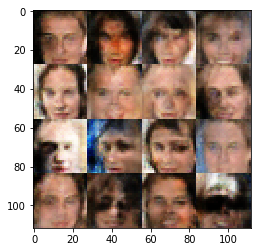

Epoch 1/2... Discriminator Loss: 1.1600... Generator Loss: 1.0762
Epoch 1/2... Discriminator Loss: 1.2404... Generator Loss: 0.8993
Epoch 1/2... Discriminator Loss: 1.2020... Generator Loss: 0.8990
Epoch 1/2... Discriminator Loss: 1.0766... Generator Loss: 1.0348
Epoch 1/2... Discriminator Loss: 1.5162... Generator Loss: 1.0505
Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 1.0678... Generator Loss: 1.0470
Epoch 1/2... Discriminator Loss: 1.2209... Generator Loss: 0.9171
Epoch 1/2... Discriminator Loss: 1.3286... Generator Loss: 1.0979
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 1.0062


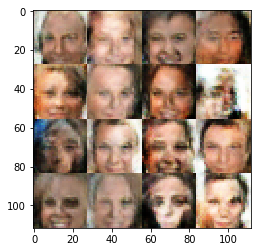

Epoch 1/2... Discriminator Loss: 0.9209... Generator Loss: 1.1825
Epoch 1/2... Discriminator Loss: 1.1911... Generator Loss: 0.9792
Epoch 1/2... Discriminator Loss: 1.2510... Generator Loss: 0.8784
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 1.0139... Generator Loss: 0.9442
Epoch 1/2... Discriminator Loss: 1.2213... Generator Loss: 1.0700
Epoch 1/2... Discriminator Loss: 1.3356... Generator Loss: 0.8136
Epoch 1/2... Discriminator Loss: 1.4393... Generator Loss: 1.1487
Epoch 1/2... Discriminator Loss: 1.2579... Generator Loss: 0.9012
Epoch 1/2... Discriminator Loss: 1.2718... Generator Loss: 1.0888


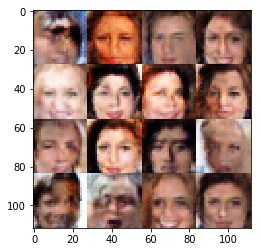

Epoch 1/2... Discriminator Loss: 1.2113... Generator Loss: 1.1144
Epoch 1/2... Discriminator Loss: 1.0087... Generator Loss: 1.2182
Epoch 1/2... Discriminator Loss: 1.3306... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 1.0530... Generator Loss: 1.2365
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.0613
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.9258
Epoch 1/2... Discriminator Loss: 1.3133... Generator Loss: 0.9779
Epoch 1/2... Discriminator Loss: 1.4095... Generator Loss: 0.7760
Epoch 1/2... Discriminator Loss: 1.3589... Generator Loss: 0.8238
Epoch 1/2... Discriminator Loss: 1.1270... Generator Loss: 1.0671


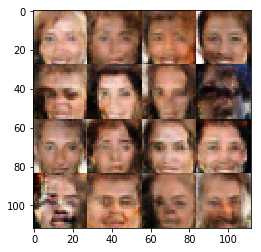

Epoch 1/2... Discriminator Loss: 1.0611... Generator Loss: 0.9184
Epoch 1/2... Discriminator Loss: 1.3225... Generator Loss: 0.7777
Epoch 1/2... Discriminator Loss: 1.3820... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 1.2283
Epoch 1/2... Discriminator Loss: 1.2087... Generator Loss: 0.9985
Epoch 1/2... Discriminator Loss: 0.9589... Generator Loss: 1.0871
Epoch 1/2... Discriminator Loss: 1.0506... Generator Loss: 1.0824
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 1.0419
Epoch 1/2... Discriminator Loss: 1.2810... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 1.2040... Generator Loss: 0.8558


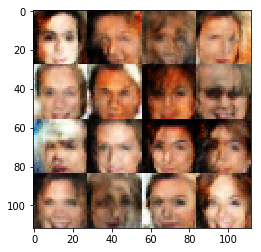

Epoch 1/2... Discriminator Loss: 1.2162... Generator Loss: 1.2303
Epoch 1/2... Discriminator Loss: 1.2170... Generator Loss: 1.0888
Epoch 1/2... Discriminator Loss: 1.3868... Generator Loss: 0.8022
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.8633
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.8031
Epoch 1/2... Discriminator Loss: 1.2246... Generator Loss: 0.9473
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 1.0838... Generator Loss: 1.1125
Epoch 1/2... Discriminator Loss: 1.3424... Generator Loss: 0.9136
Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 0.8485


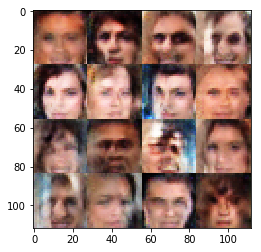

Epoch 1/2... Discriminator Loss: 1.1637... Generator Loss: 0.9027
Epoch 1/2... Discriminator Loss: 1.1903... Generator Loss: 0.9535
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 1.1137
Epoch 1/2... Discriminator Loss: 1.2283... Generator Loss: 1.2305
Epoch 1/2... Discriminator Loss: 1.2445... Generator Loss: 0.9955
Epoch 1/2... Discriminator Loss: 1.3808... Generator Loss: 0.8625
Epoch 1/2... Discriminator Loss: 1.1152... Generator Loss: 1.0622
Epoch 1/2... Discriminator Loss: 1.2983... Generator Loss: 0.9787
Epoch 1/2... Discriminator Loss: 1.2312... Generator Loss: 0.9008
Epoch 1/2... Discriminator Loss: 1.0684... Generator Loss: 0.8191


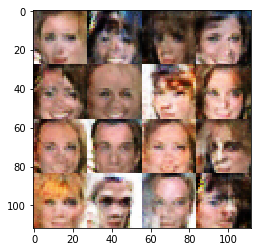

Epoch 1/2... Discriminator Loss: 1.2840... Generator Loss: 1.0524
Epoch 1/2... Discriminator Loss: 1.3160... Generator Loss: 0.8108
Epoch 1/2... Discriminator Loss: 1.1975... Generator Loss: 0.7838
Epoch 1/2... Discriminator Loss: 1.3319... Generator Loss: 0.8870
Epoch 1/2... Discriminator Loss: 1.1814... Generator Loss: 1.0539
Epoch 1/2... Discriminator Loss: 0.9565... Generator Loss: 1.3098
Epoch 1/2... Discriminator Loss: 1.4317... Generator Loss: 0.7693
Epoch 1/2... Discriminator Loss: 1.3384... Generator Loss: 1.2525
Epoch 1/2... Discriminator Loss: 1.1479... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.3601... Generator Loss: 0.9610


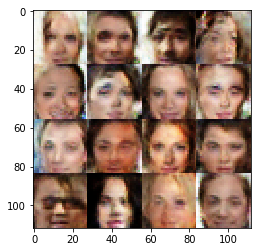

Epoch 1/2... Discriminator Loss: 1.3057... Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 0.8713
Epoch 1/2... Discriminator Loss: 1.1069... Generator Loss: 1.0098
Epoch 1/2... Discriminator Loss: 1.2335... Generator Loss: 1.1381
Epoch 1/2... Discriminator Loss: 1.3171... Generator Loss: 0.7321
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 1.0162
Epoch 1/2... Discriminator Loss: 1.4402... Generator Loss: 0.8195
Epoch 1/2... Discriminator Loss: 1.0991... Generator Loss: 1.0681
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 1.1915


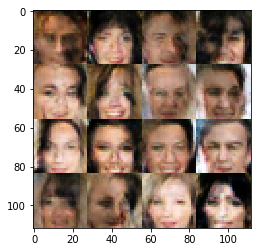

Epoch 1/2... Discriminator Loss: 1.1235... Generator Loss: 1.1420
Epoch 1/2... Discriminator Loss: 1.2509... Generator Loss: 1.1787
Epoch 1/2... Discriminator Loss: 1.3597... Generator Loss: 0.7383
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 1.1357
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.8065
Epoch 1/2... Discriminator Loss: 1.2256... Generator Loss: 1.0435
Epoch 1/2... Discriminator Loss: 1.1919... Generator Loss: 1.1279
Epoch 1/2... Discriminator Loss: 1.3701... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 1.2055... Generator Loss: 1.1137
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 0.9978


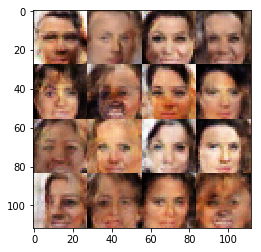

Epoch 1/2... Discriminator Loss: 1.1286... Generator Loss: 0.8477
Epoch 1/2... Discriminator Loss: 1.2429... Generator Loss: 1.1384
Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 1.0999
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.9129
Epoch 1/2... Discriminator Loss: 1.2070... Generator Loss: 1.2150
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.7380
Epoch 1/2... Discriminator Loss: 1.1256... Generator Loss: 0.8981
Epoch 1/2... Discriminator Loss: 1.2613... Generator Loss: 1.2922
Epoch 1/2... Discriminator Loss: 1.2353... Generator Loss: 1.1848
Epoch 1/2... Discriminator Loss: 1.2480... Generator Loss: 0.9017


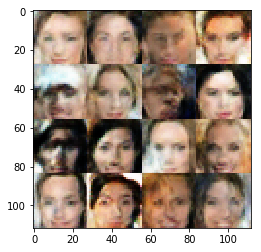

Epoch 1/2... Discriminator Loss: 1.2425... Generator Loss: 0.8422
Epoch 1/2... Discriminator Loss: 1.4662... Generator Loss: 1.0454
Epoch 1/2... Discriminator Loss: 1.5251... Generator Loss: 0.8119
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 0.9239
Epoch 1/2... Discriminator Loss: 1.2119... Generator Loss: 0.8448
Epoch 1/2... Discriminator Loss: 1.2876... Generator Loss: 0.8444
Epoch 1/2... Discriminator Loss: 1.1699... Generator Loss: 1.0672
Epoch 1/2... Discriminator Loss: 1.3620... Generator Loss: 0.9975
Epoch 1/2... Discriminator Loss: 1.0619... Generator Loss: 1.5556
Epoch 1/2... Discriminator Loss: 1.3413... Generator Loss: 0.9180


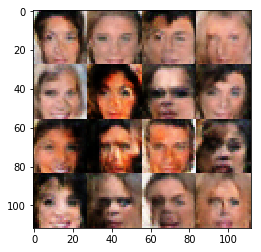

Epoch 1/2... Discriminator Loss: 1.1775... Generator Loss: 1.1730
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 1.0310
Epoch 1/2... Discriminator Loss: 1.4366... Generator Loss: 0.9235
Epoch 1/2... Discriminator Loss: 1.1443... Generator Loss: 1.1567
Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.9109
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 0.9233
Epoch 1/2... Discriminator Loss: 1.1451... Generator Loss: 0.9170
Epoch 1/2... Discriminator Loss: 1.2403... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 1.1742... Generator Loss: 1.0886
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 1.0412


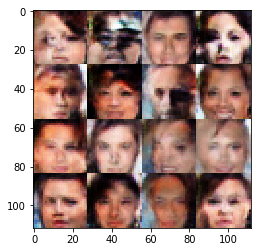

Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 1.2276
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.2279... Generator Loss: 1.1763
Epoch 1/2... Discriminator Loss: 1.0532... Generator Loss: 1.1497
Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 1.1601
Epoch 1/2... Discriminator Loss: 1.1713... Generator Loss: 0.9583
Epoch 1/2... Discriminator Loss: 1.3481... Generator Loss: 1.5655
Epoch 1/2... Discriminator Loss: 1.0814... Generator Loss: 1.5997
Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 1.0652
Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 1.2134


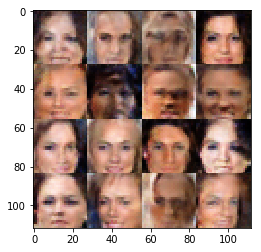

Epoch 1/2... Discriminator Loss: 1.0001... Generator Loss: 1.0658
Epoch 1/2... Discriminator Loss: 1.3235... Generator Loss: 0.9625
Epoch 1/2... Discriminator Loss: 1.4848... Generator Loss: 1.2363
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.9848
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 1.0524
Epoch 1/2... Discriminator Loss: 1.1031... Generator Loss: 0.7656
Epoch 1/2... Discriminator Loss: 1.1759... Generator Loss: 0.9787
Epoch 1/2... Discriminator Loss: 1.1918... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 1.2850... Generator Loss: 1.1700
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 1.3785


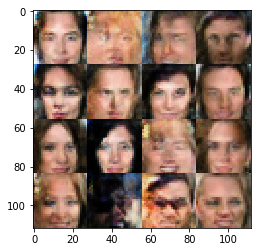

Epoch 1/2... Discriminator Loss: 1.1440... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 1.0919
Epoch 1/2... Discriminator Loss: 1.2608... Generator Loss: 1.0914
Epoch 1/2... Discriminator Loss: 1.2136... Generator Loss: 0.9298
Epoch 1/2... Discriminator Loss: 1.1706... Generator Loss: 0.8642
Epoch 1/2... Discriminator Loss: 1.2369... Generator Loss: 1.0481
Epoch 1/2... Discriminator Loss: 1.1045... Generator Loss: 1.1463
Epoch 1/2... Discriminator Loss: 1.0921... Generator Loss: 1.0832
Epoch 1/2... Discriminator Loss: 1.2370... Generator Loss: 0.9174
Epoch 1/2... Discriminator Loss: 1.1260... Generator Loss: 1.0326


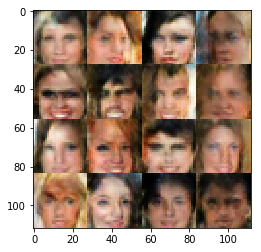

Epoch 1/2... Discriminator Loss: 1.3330... Generator Loss: 0.9000
Epoch 1/2... Discriminator Loss: 1.2543... Generator Loss: 0.9716
Epoch 1/2... Discriminator Loss: 1.2382... Generator Loss: 1.0923
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 1.1655
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 0.7250
Epoch 1/2... Discriminator Loss: 1.2747... Generator Loss: 0.7992
Epoch 1/2... Discriminator Loss: 1.2194... Generator Loss: 1.1832
Epoch 1/2... Discriminator Loss: 1.0046... Generator Loss: 1.1143


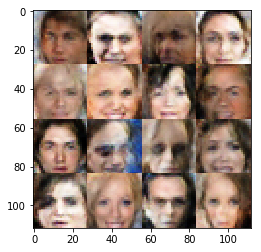

Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.8868
Epoch 1/2... Discriminator Loss: 1.1604... Generator Loss: 0.8055
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.9512
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.8430
Epoch 1/2... Discriminator Loss: 1.2743... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.4541... Generator Loss: 0.9180
Epoch 1/2... Discriminator Loss: 1.2317... Generator Loss: 0.9917
Epoch 1/2... Discriminator Loss: 1.4413... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 1.3183... Generator Loss: 1.0872
Epoch 1/2... Discriminator Loss: 1.1789... Generator Loss: 0.9806


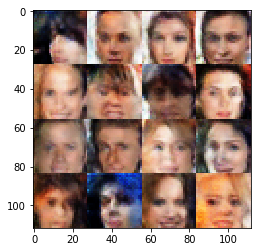

Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.9080
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.9826
Epoch 1/2... Discriminator Loss: 1.3150... Generator Loss: 0.8441
Epoch 1/2... Discriminator Loss: 1.2597... Generator Loss: 0.9873
Epoch 1/2... Discriminator Loss: 1.4088... Generator Loss: 0.9672
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.8766
Epoch 1/2... Discriminator Loss: 1.2125... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 1.1586... Generator Loss: 1.0304
Epoch 1/2... Discriminator Loss: 1.3126... Generator Loss: 1.1472
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 1.1073


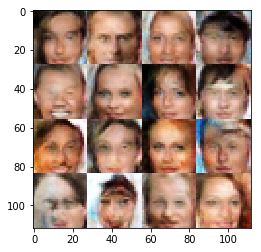

Epoch 1/2... Discriminator Loss: 1.0774... Generator Loss: 1.1249
Epoch 1/2... Discriminator Loss: 1.2917... Generator Loss: 1.0151
Epoch 1/2... Discriminator Loss: 1.4247... Generator Loss: 1.0799
Epoch 1/2... Discriminator Loss: 1.1988... Generator Loss: 0.8557
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 0.8225
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 1.0822
Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 1.4121
Epoch 1/2... Discriminator Loss: 1.1986... Generator Loss: 1.3329
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 1.3351
Epoch 1/2... Discriminator Loss: 1.2175... Generator Loss: 0.9267


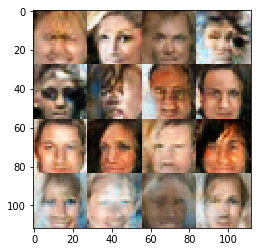

Epoch 1/2... Discriminator Loss: 1.4189... Generator Loss: 0.9792
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 0.9165
Epoch 1/2... Discriminator Loss: 1.1253... Generator Loss: 1.1303
Epoch 1/2... Discriminator Loss: 1.2069... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 1.0122... Generator Loss: 0.9656
Epoch 1/2... Discriminator Loss: 1.3321... Generator Loss: 0.7843
Epoch 1/2... Discriminator Loss: 1.2790... Generator Loss: 0.9821
Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 0.9255
Epoch 1/2... Discriminator Loss: 1.4367... Generator Loss: 1.0281
Epoch 1/2... Discriminator Loss: 1.1285... Generator Loss: 1.1990


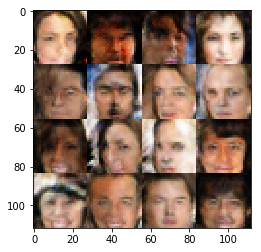

Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.1650... Generator Loss: 1.1385
Epoch 1/2... Discriminator Loss: 1.1630... Generator Loss: 1.0637
Epoch 1/2... Discriminator Loss: 1.2490... Generator Loss: 1.0001
Epoch 1/2... Discriminator Loss: 1.3688... Generator Loss: 1.0858
Epoch 1/2... Discriminator Loss: 1.1335... Generator Loss: 0.8527
Epoch 1/2... Discriminator Loss: 1.2261... Generator Loss: 0.9484
Epoch 1/2... Discriminator Loss: 1.0668... Generator Loss: 1.0507
Epoch 1/2... Discriminator Loss: 1.2333... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.2702... Generator Loss: 0.9308


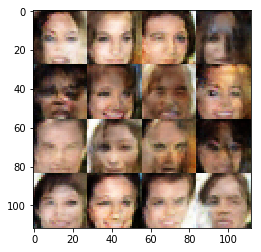

Epoch 1/2... Discriminator Loss: 1.1643... Generator Loss: 1.0368
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 1.4179
Epoch 1/2... Discriminator Loss: 1.1181... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 1.1571... Generator Loss: 0.8002
Epoch 1/2... Discriminator Loss: 1.1828... Generator Loss: 0.9041
Epoch 1/2... Discriminator Loss: 1.3692... Generator Loss: 0.9544
Epoch 1/2... Discriminator Loss: 1.6261... Generator Loss: 0.6505
Epoch 1/2... Discriminator Loss: 1.0566... Generator Loss: 0.9793
Epoch 1/2... Discriminator Loss: 1.2074... Generator Loss: 1.0103
Epoch 1/2... Discriminator Loss: 1.2521... Generator Loss: 1.2278


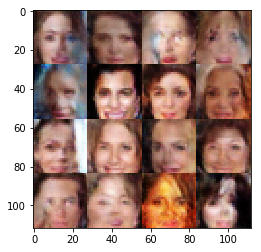

Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 0.8360
Epoch 1/2... Discriminator Loss: 1.2482... Generator Loss: 0.9172
Epoch 1/2... Discriminator Loss: 1.1510... Generator Loss: 1.0113
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 1.2478
Epoch 2/2... Discriminator Loss: 1.1272... Generator Loss: 1.2744
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.8416
Epoch 2/2... Discriminator Loss: 1.3488... Generator Loss: 1.0005
Epoch 2/2... Discriminator Loss: 1.5629... Generator Loss: 0.8177
Epoch 2/2... Discriminator Loss: 1.0698... Generator Loss: 1.3300
Epoch 2/2... Discriminator Loss: 1.1523... Generator Loss: 0.8216


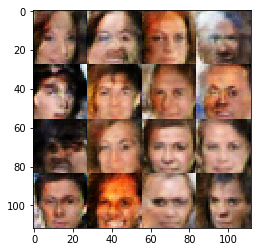

Epoch 2/2... Discriminator Loss: 1.0933... Generator Loss: 1.1178
Epoch 2/2... Discriminator Loss: 1.3221... Generator Loss: 0.9257
Epoch 2/2... Discriminator Loss: 1.0660... Generator Loss: 0.9109
Epoch 2/2... Discriminator Loss: 1.2155... Generator Loss: 0.9089
Epoch 2/2... Discriminator Loss: 1.2870... Generator Loss: 0.9896
Epoch 2/2... Discriminator Loss: 1.3166... Generator Loss: 1.0017
Epoch 2/2... Discriminator Loss: 1.3603... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 1.1024... Generator Loss: 0.8912
Epoch 2/2... Discriminator Loss: 1.2840... Generator Loss: 0.7400
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 0.7922


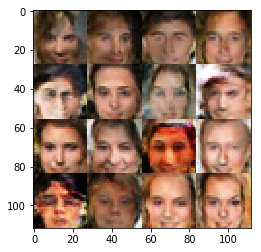

Epoch 2/2... Discriminator Loss: 1.2289... Generator Loss: 1.1251
Epoch 2/2... Discriminator Loss: 1.1879... Generator Loss: 1.2049
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 1.0057
Epoch 2/2... Discriminator Loss: 1.1444... Generator Loss: 1.0281
Epoch 2/2... Discriminator Loss: 1.4790... Generator Loss: 1.0814
Epoch 2/2... Discriminator Loss: 1.2658... Generator Loss: 0.8217
Epoch 2/2... Discriminator Loss: 1.3929... Generator Loss: 0.7015
Epoch 2/2... Discriminator Loss: 1.1346... Generator Loss: 0.8597
Epoch 2/2... Discriminator Loss: 1.0166... Generator Loss: 0.9647
Epoch 2/2... Discriminator Loss: 1.2760... Generator Loss: 0.6748


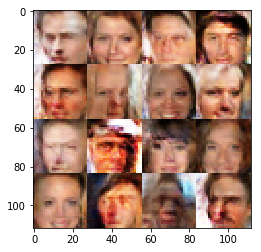

Epoch 2/2... Discriminator Loss: 1.1397... Generator Loss: 1.0728
Epoch 2/2... Discriminator Loss: 1.2625... Generator Loss: 0.7346
Epoch 2/2... Discriminator Loss: 1.3125... Generator Loss: 0.8889
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.9145
Epoch 2/2... Discriminator Loss: 1.2335... Generator Loss: 1.0230
Epoch 2/2... Discriminator Loss: 1.2391... Generator Loss: 0.9153
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 1.1927
Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 1.2958... Generator Loss: 0.9724
Epoch 2/2... Discriminator Loss: 1.1558... Generator Loss: 0.9611


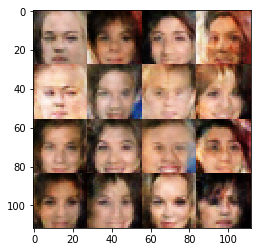

Epoch 2/2... Discriminator Loss: 1.3210... Generator Loss: 1.0360
Epoch 2/2... Discriminator Loss: 1.0608... Generator Loss: 0.9697
Epoch 2/2... Discriminator Loss: 1.1463... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 1.2050... Generator Loss: 0.9582
Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 1.0001
Epoch 2/2... Discriminator Loss: 1.1897... Generator Loss: 0.7616
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.8838
Epoch 2/2... Discriminator Loss: 1.6000... Generator Loss: 0.6091
Epoch 2/2... Discriminator Loss: 1.2784... Generator Loss: 1.0652
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 0.9278


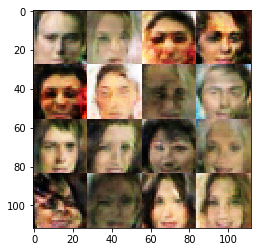

Epoch 2/2... Discriminator Loss: 1.4884... Generator Loss: 1.0722
Epoch 2/2... Discriminator Loss: 1.4503... Generator Loss: 0.7107
Epoch 2/2... Discriminator Loss: 1.3600... Generator Loss: 0.7295
Epoch 2/2... Discriminator Loss: 1.1384... Generator Loss: 1.0436
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.9838
Epoch 2/2... Discriminator Loss: 1.2451... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 1.1732... Generator Loss: 1.0815
Epoch 2/2... Discriminator Loss: 1.2268... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.8766
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.9374


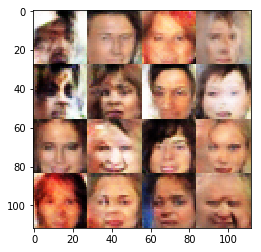

Epoch 2/2... Discriminator Loss: 1.1547... Generator Loss: 1.1269
Epoch 2/2... Discriminator Loss: 1.2761... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.5210... Generator Loss: 1.0408
Epoch 2/2... Discriminator Loss: 1.2751... Generator Loss: 0.8491
Epoch 2/2... Discriminator Loss: 1.3398... Generator Loss: 0.7797
Epoch 2/2... Discriminator Loss: 1.3280... Generator Loss: 0.9071
Epoch 2/2... Discriminator Loss: 1.7575... Generator Loss: 0.8182
Epoch 2/2... Discriminator Loss: 1.2365... Generator Loss: 1.1488
Epoch 2/2... Discriminator Loss: 1.1252... Generator Loss: 0.9543
Epoch 2/2... Discriminator Loss: 1.0918... Generator Loss: 1.0147


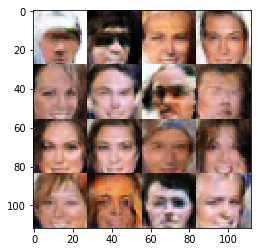

Epoch 2/2... Discriminator Loss: 1.1443... Generator Loss: 1.2352
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.9481
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.9918
Epoch 2/2... Discriminator Loss: 1.2551... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 1.0478... Generator Loss: 1.1843
Epoch 2/2... Discriminator Loss: 1.4537... Generator Loss: 0.6857
Epoch 2/2... Discriminator Loss: 1.2948... Generator Loss: 0.9009
Epoch 2/2... Discriminator Loss: 1.0875... Generator Loss: 0.9418
Epoch 2/2... Discriminator Loss: 1.2961... Generator Loss: 1.0711
Epoch 2/2... Discriminator Loss: 1.2910... Generator Loss: 0.7661


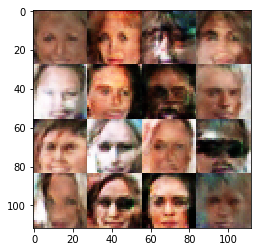

Epoch 2/2... Discriminator Loss: 1.4075... Generator Loss: 0.8772
Epoch 2/2... Discriminator Loss: 1.4942... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 1.2708... Generator Loss: 0.8813
Epoch 2/2... Discriminator Loss: 1.2350... Generator Loss: 1.0097
Epoch 2/2... Discriminator Loss: 1.1716... Generator Loss: 0.8856
Epoch 2/2... Discriminator Loss: 1.2462... Generator Loss: 1.2509
Epoch 2/2... Discriminator Loss: 1.4305... Generator Loss: 1.0218
Epoch 2/2... Discriminator Loss: 1.0948... Generator Loss: 0.9948
Epoch 2/2... Discriminator Loss: 1.0614... Generator Loss: 0.9138
Epoch 2/2... Discriminator Loss: 1.1406... Generator Loss: 0.9969


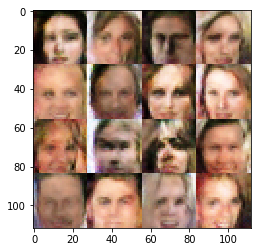

Epoch 2/2... Discriminator Loss: 1.2330... Generator Loss: 0.9809
Epoch 2/2... Discriminator Loss: 1.1258... Generator Loss: 0.9293
Epoch 2/2... Discriminator Loss: 1.2378... Generator Loss: 1.1352
Epoch 2/2... Discriminator Loss: 1.3149... Generator Loss: 0.9729
Epoch 2/2... Discriminator Loss: 1.1584... Generator Loss: 1.0035
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.9186
Epoch 2/2... Discriminator Loss: 1.2453... Generator Loss: 0.8925
Epoch 2/2... Discriminator Loss: 1.3115... Generator Loss: 0.7019
Epoch 2/2... Discriminator Loss: 1.2054... Generator Loss: 0.9580
Epoch 2/2... Discriminator Loss: 1.1671... Generator Loss: 1.0031


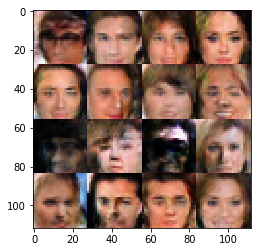

Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 1.1546
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 1.0643
Epoch 2/2... Discriminator Loss: 1.2917... Generator Loss: 1.0962
Epoch 2/2... Discriminator Loss: 1.1884... Generator Loss: 1.1786
Epoch 2/2... Discriminator Loss: 1.2300... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 1.4256... Generator Loss: 0.9011
Epoch 2/2... Discriminator Loss: 1.4141... Generator Loss: 0.7883
Epoch 2/2... Discriminator Loss: 1.0049... Generator Loss: 1.4609
Epoch 2/2... Discriminator Loss: 1.0504... Generator Loss: 1.0155


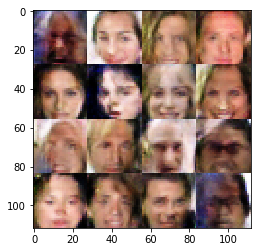

Epoch 2/2... Discriminator Loss: 1.5119... Generator Loss: 0.7329
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.9183
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 1.1835
Epoch 2/2... Discriminator Loss: 1.3086... Generator Loss: 1.1216
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 0.8991
Epoch 2/2... Discriminator Loss: 1.1662... Generator Loss: 1.2243
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 1.0157... Generator Loss: 1.2108
Epoch 2/2... Discriminator Loss: 1.2812... Generator Loss: 0.9859
Epoch 2/2... Discriminator Loss: 1.1334... Generator Loss: 1.0111


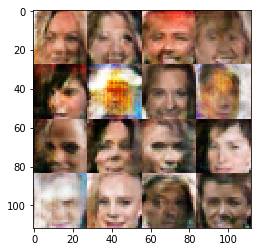

Epoch 2/2... Discriminator Loss: 1.1288... Generator Loss: 1.1032
Epoch 2/2... Discriminator Loss: 1.0918... Generator Loss: 0.9634
Epoch 2/2... Discriminator Loss: 1.0271... Generator Loss: 0.9870
Epoch 2/2... Discriminator Loss: 1.4070... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 1.1470... Generator Loss: 0.8980
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 0.8794
Epoch 2/2... Discriminator Loss: 1.3612... Generator Loss: 0.7984
Epoch 2/2... Discriminator Loss: 1.4553... Generator Loss: 0.7524
Epoch 2/2... Discriminator Loss: 1.5008... Generator Loss: 1.1749
Epoch 2/2... Discriminator Loss: 1.1599... Generator Loss: 1.1051


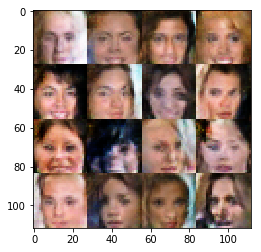

Epoch 2/2... Discriminator Loss: 1.2942... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.0978... Generator Loss: 0.7580
Epoch 2/2... Discriminator Loss: 1.0246... Generator Loss: 1.0042
Epoch 2/2... Discriminator Loss: 1.1100... Generator Loss: 0.9175
Epoch 2/2... Discriminator Loss: 1.4325... Generator Loss: 0.7819
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 1.1742
Epoch 2/2... Discriminator Loss: 1.3386... Generator Loss: 0.8515
Epoch 2/2... Discriminator Loss: 1.3145... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 1.2518... Generator Loss: 0.8877
Epoch 2/2... Discriminator Loss: 1.0932... Generator Loss: 0.8450


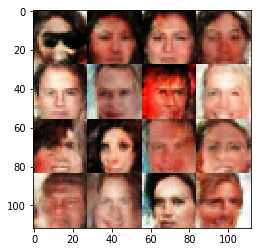

Epoch 2/2... Discriminator Loss: 1.5695... Generator Loss: 0.6528
Epoch 2/2... Discriminator Loss: 1.0525... Generator Loss: 0.7806
Epoch 2/2... Discriminator Loss: 1.1213... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 1.1741... Generator Loss: 1.1745
Epoch 2/2... Discriminator Loss: 1.4198... Generator Loss: 0.8295
Epoch 2/2... Discriminator Loss: 1.2771... Generator Loss: 0.8462
Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 0.9652
Epoch 2/2... Discriminator Loss: 1.2716... Generator Loss: 1.0108
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 0.9109
Epoch 2/2... Discriminator Loss: 1.3319... Generator Loss: 1.0137


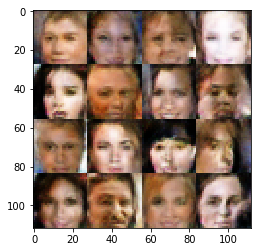

Epoch 2/2... Discriminator Loss: 1.4682... Generator Loss: 0.9855
Epoch 2/2... Discriminator Loss: 1.2747... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 1.2766... Generator Loss: 1.4195
Epoch 2/2... Discriminator Loss: 1.1758... Generator Loss: 0.8503
Epoch 2/2... Discriminator Loss: 1.1663... Generator Loss: 0.9761
Epoch 2/2... Discriminator Loss: 1.1718... Generator Loss: 1.2259
Epoch 2/2... Discriminator Loss: 0.9548... Generator Loss: 1.1201
Epoch 2/2... Discriminator Loss: 1.0586... Generator Loss: 0.8958
Epoch 2/2... Discriminator Loss: 1.0081... Generator Loss: 0.9752
Epoch 2/2... Discriminator Loss: 1.1665... Generator Loss: 0.9509


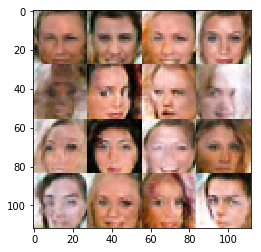

Epoch 2/2... Discriminator Loss: 1.2734... Generator Loss: 0.9940
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.7035
Epoch 2/2... Discriminator Loss: 1.1304... Generator Loss: 0.9394
Epoch 2/2... Discriminator Loss: 1.5007... Generator Loss: 0.7611
Epoch 2/2... Discriminator Loss: 1.2150... Generator Loss: 0.8511
Epoch 2/2... Discriminator Loss: 1.4658... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 0.9741... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 1.2259... Generator Loss: 1.0776
Epoch 2/2... Discriminator Loss: 1.1302... Generator Loss: 0.9692
Epoch 2/2... Discriminator Loss: 1.2879... Generator Loss: 0.9803


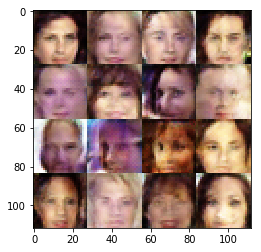

Epoch 2/2... Discriminator Loss: 1.2614... Generator Loss: 0.7066
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 1.2315
Epoch 2/2... Discriminator Loss: 1.3450... Generator Loss: 0.8953
Epoch 2/2... Discriminator Loss: 1.5129... Generator Loss: 0.8524
Epoch 2/2... Discriminator Loss: 1.2949... Generator Loss: 0.8822
Epoch 2/2... Discriminator Loss: 1.0817... Generator Loss: 1.2107
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.8356
Epoch 2/2... Discriminator Loss: 1.2832... Generator Loss: 0.7515
Epoch 2/2... Discriminator Loss: 1.2841... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 1.0192


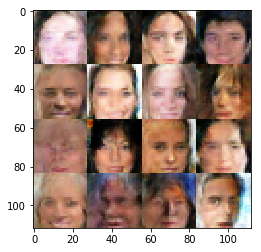

Epoch 2/2... Discriminator Loss: 1.3162... Generator Loss: 0.7962
Epoch 2/2... Discriminator Loss: 1.1359... Generator Loss: 1.0229
Epoch 2/2... Discriminator Loss: 1.2369... Generator Loss: 1.2985
Epoch 2/2... Discriminator Loss: 1.2041... Generator Loss: 0.9243
Epoch 2/2... Discriminator Loss: 1.2194... Generator Loss: 0.8952
Epoch 2/2... Discriminator Loss: 1.2958... Generator Loss: 0.8464
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 1.0209
Epoch 2/2... Discriminator Loss: 1.2779... Generator Loss: 0.9590
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 0.7847
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.7712


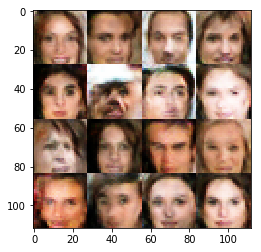

Epoch 2/2... Discriminator Loss: 1.2525... Generator Loss: 1.0529
Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 1.0083
Epoch 2/2... Discriminator Loss: 1.4186... Generator Loss: 0.8332
Epoch 2/2... Discriminator Loss: 1.1460... Generator Loss: 1.1825
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 1.1323
Epoch 2/2... Discriminator Loss: 1.1227... Generator Loss: 0.9225
Epoch 2/2... Discriminator Loss: 1.3829... Generator Loss: 1.3144
Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 0.9132
Epoch 2/2... Discriminator Loss: 0.9274... Generator Loss: 1.4806
Epoch 2/2... Discriminator Loss: 0.9879... Generator Loss: 1.8439


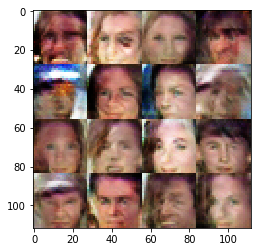

Epoch 2/2... Discriminator Loss: 1.0438... Generator Loss: 0.9783
Epoch 2/2... Discriminator Loss: 1.0742... Generator Loss: 0.8649
Epoch 2/2... Discriminator Loss: 1.0126... Generator Loss: 0.9253
Epoch 2/2... Discriminator Loss: 1.3441... Generator Loss: 1.1321
Epoch 2/2... Discriminator Loss: 1.3984... Generator Loss: 1.1329
Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.7945
Epoch 2/2... Discriminator Loss: 1.0854... Generator Loss: 1.2674
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 1.1985
Epoch 2/2... Discriminator Loss: 1.1375... Generator Loss: 1.0726
Epoch 2/2... Discriminator Loss: 1.0263... Generator Loss: 0.8112


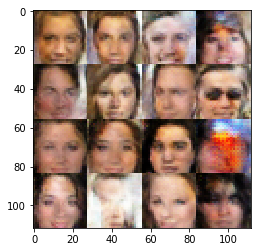

Epoch 2/2... Discriminator Loss: 1.1441... Generator Loss: 0.9534
Epoch 2/2... Discriminator Loss: 1.1139... Generator Loss: 1.0462
Epoch 2/2... Discriminator Loss: 1.0800... Generator Loss: 1.0053
Epoch 2/2... Discriminator Loss: 1.0726... Generator Loss: 0.8800
Epoch 2/2... Discriminator Loss: 1.1538... Generator Loss: 0.7419
Epoch 2/2... Discriminator Loss: 1.2019... Generator Loss: 0.9254
Epoch 2/2... Discriminator Loss: 1.2580... Generator Loss: 1.0368
Epoch 2/2... Discriminator Loss: 1.3651... Generator Loss: 0.8221
Epoch 2/2... Discriminator Loss: 1.5546... Generator Loss: 0.8365
Epoch 2/2... Discriminator Loss: 1.3544... Generator Loss: 0.7455


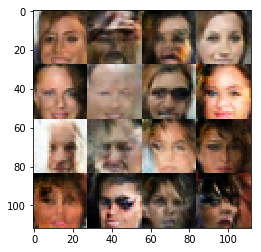

Epoch 2/2... Discriminator Loss: 1.2274... Generator Loss: 1.0072
Epoch 2/2... Discriminator Loss: 1.4235... Generator Loss: 0.9783
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 0.9514
Epoch 2/2... Discriminator Loss: 1.2200... Generator Loss: 0.8212
Epoch 2/2... Discriminator Loss: 1.3048... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 1.1063... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 1.1342... Generator Loss: 0.8508
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.9698
Epoch 2/2... Discriminator Loss: 1.2703... Generator Loss: 0.8700
Epoch 2/2... Discriminator Loss: 1.3195... Generator Loss: 1.0463


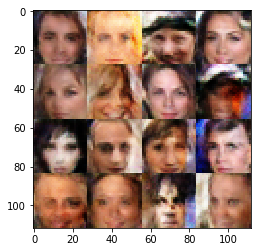

Epoch 2/2... Discriminator Loss: 1.2752... Generator Loss: 1.0624
Epoch 2/2... Discriminator Loss: 1.4022... Generator Loss: 0.8497
Epoch 2/2... Discriminator Loss: 1.0330... Generator Loss: 1.1862
Epoch 2/2... Discriminator Loss: 1.3239... Generator Loss: 0.8615
Epoch 2/2... Discriminator Loss: 1.2057... Generator Loss: 1.2645
Epoch 2/2... Discriminator Loss: 1.2401... Generator Loss: 0.8946
Epoch 2/2... Discriminator Loss: 1.1736... Generator Loss: 0.8679
Epoch 2/2... Discriminator Loss: 1.3236... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 1.1435
Epoch 2/2... Discriminator Loss: 1.1045... Generator Loss: 1.0499


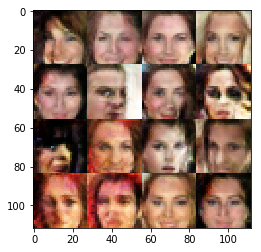

Epoch 2/2... Discriminator Loss: 1.1306... Generator Loss: 1.0729
Epoch 2/2... Discriminator Loss: 1.0251... Generator Loss: 1.0808
Epoch 2/2... Discriminator Loss: 1.2239... Generator Loss: 0.9805
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 0.9383
Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.9862
Epoch 2/2... Discriminator Loss: 0.9200... Generator Loss: 1.2807
Epoch 2/2... Discriminator Loss: 0.9489... Generator Loss: 1.1892
Epoch 2/2... Discriminator Loss: 1.3203... Generator Loss: 1.1224
Epoch 2/2... Discriminator Loss: 1.0461... Generator Loss: 0.9707
Epoch 2/2... Discriminator Loss: 1.1358... Generator Loss: 1.1901


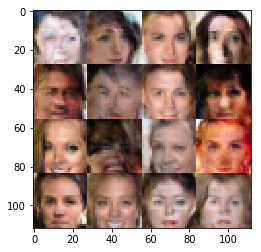

Epoch 2/2... Discriminator Loss: 1.2032... Generator Loss: 0.9984
Epoch 2/2... Discriminator Loss: 1.2822... Generator Loss: 1.0173
Epoch 2/2... Discriminator Loss: 1.4633... Generator Loss: 1.0033
Epoch 2/2... Discriminator Loss: 0.9234... Generator Loss: 0.8999
Epoch 2/2... Discriminator Loss: 1.2641... Generator Loss: 1.0961
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 1.0095
Epoch 2/2... Discriminator Loss: 1.1702... Generator Loss: 0.7729
Epoch 2/2... Discriminator Loss: 1.1641... Generator Loss: 0.8253
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 1.3396
Epoch 2/2... Discriminator Loss: 1.2544... Generator Loss: 0.9210


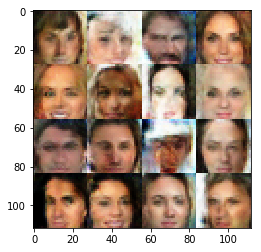

Epoch 2/2... Discriminator Loss: 1.2831... Generator Loss: 0.9670
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 0.9432
Epoch 2/2... Discriminator Loss: 1.3511... Generator Loss: 0.6589
Epoch 2/2... Discriminator Loss: 1.5015... Generator Loss: 0.7874
Epoch 2/2... Discriminator Loss: 1.1330... Generator Loss: 0.8855
Epoch 2/2... Discriminator Loss: 1.1661... Generator Loss: 1.1192
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 1.0784
Epoch 2/2... Discriminator Loss: 1.2025... Generator Loss: 0.9819
Epoch 2/2... Discriminator Loss: 1.0026... Generator Loss: 0.9847
Epoch 2/2... Discriminator Loss: 1.0074... Generator Loss: 1.2889


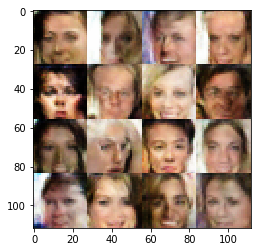

Epoch 2/2... Discriminator Loss: 1.3596... Generator Loss: 0.8746
Epoch 2/2... Discriminator Loss: 1.2949... Generator Loss: 0.8830
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.8199
Epoch 2/2... Discriminator Loss: 1.2183... Generator Loss: 0.7232
Epoch 2/2... Discriminator Loss: 1.2102... Generator Loss: 1.0365
Epoch 2/2... Discriminator Loss: 1.2230... Generator Loss: 0.8390
Epoch 2/2... Discriminator Loss: 1.3042... Generator Loss: 0.7432
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 1.0228
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 1.0390
Epoch 2/2... Discriminator Loss: 1.1874... Generator Loss: 1.0527


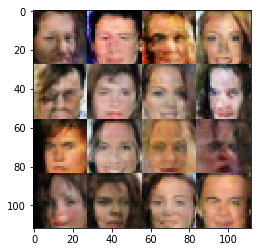

Epoch 2/2... Discriminator Loss: 1.0477... Generator Loss: 1.2711
Epoch 2/2... Discriminator Loss: 1.2397... Generator Loss: 0.7906
Epoch 2/2... Discriminator Loss: 1.1255... Generator Loss: 1.0489
Epoch 2/2... Discriminator Loss: 1.0851... Generator Loss: 1.0060
Epoch 2/2... Discriminator Loss: 1.2428... Generator Loss: 1.1620
Epoch 2/2... Discriminator Loss: 1.2393... Generator Loss: 0.8525
Epoch 2/2... Discriminator Loss: 1.3693... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.3405... Generator Loss: 1.5929
Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 1.0414
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 1.1588


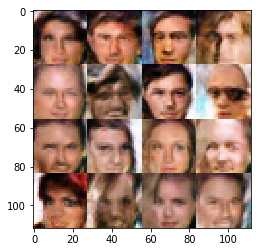

Epoch 2/2... Discriminator Loss: 1.3752... Generator Loss: 1.0871
Epoch 2/2... Discriminator Loss: 1.0997... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 1.2606... Generator Loss: 1.1056
Epoch 2/2... Discriminator Loss: 1.1714... Generator Loss: 0.9031
Epoch 2/2... Discriminator Loss: 1.3366... Generator Loss: 0.8572
Epoch 2/2... Discriminator Loss: 1.1587... Generator Loss: 0.8399
Epoch 2/2... Discriminator Loss: 1.1927... Generator Loss: 0.7434
Epoch 2/2... Discriminator Loss: 1.2945... Generator Loss: 0.7750
Epoch 2/2... Discriminator Loss: 1.1751... Generator Loss: 0.9253
Epoch 2/2... Discriminator Loss: 0.9998... Generator Loss: 1.1927


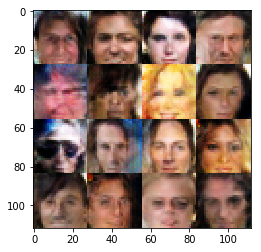

Epoch 2/2... Discriminator Loss: 1.3565... Generator Loss: 1.0086
Epoch 2/2... Discriminator Loss: 1.3582... Generator Loss: 0.8902
Epoch 2/2... Discriminator Loss: 1.0419... Generator Loss: 1.0570
Epoch 2/2... Discriminator Loss: 1.1486... Generator Loss: 0.8384
Epoch 2/2... Discriminator Loss: 1.2592... Generator Loss: 0.9126
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 0.7224
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 0.9849
Epoch 2/2... Discriminator Loss: 1.1907... Generator Loss: 1.0123
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 1.2946... Generator Loss: 1.1081


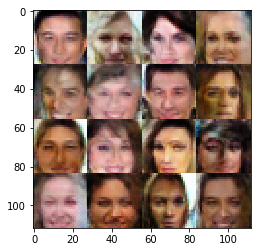

Epoch 2/2... Discriminator Loss: 1.1590... Generator Loss: 1.1647
Epoch 2/2... Discriminator Loss: 1.1248... Generator Loss: 1.1523
Epoch 2/2... Discriminator Loss: 1.2680... Generator Loss: 0.8366
Epoch 2/2... Discriminator Loss: 1.0194... Generator Loss: 0.9995
Epoch 2/2... Discriminator Loss: 1.1683... Generator Loss: 1.0480
Epoch 2/2... Discriminator Loss: 1.1831... Generator Loss: 0.8817
Epoch 2/2... Discriminator Loss: 1.3883... Generator Loss: 0.9515
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 1.0333
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.8557
Epoch 2/2... Discriminator Loss: 1.1465... Generator Loss: 0.9618


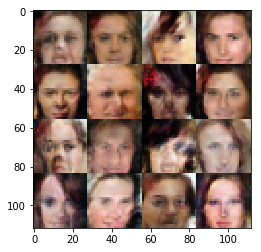

Epoch 2/2... Discriminator Loss: 1.2304... Generator Loss: 0.9786
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 0.9600
Epoch 2/2... Discriminator Loss: 1.1386... Generator Loss: 0.8429
Epoch 2/2... Discriminator Loss: 1.4755... Generator Loss: 1.1042
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.9554
Epoch 2/2... Discriminator Loss: 1.1051... Generator Loss: 1.2164
Epoch 2/2... Discriminator Loss: 1.4827... Generator Loss: 0.7468
Epoch 2/2... Discriminator Loss: 1.3004... Generator Loss: 0.8341
Epoch 2/2... Discriminator Loss: 1.2480... Generator Loss: 1.0138
Epoch 2/2... Discriminator Loss: 1.2275... Generator Loss: 1.0161


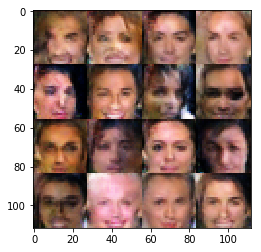

Epoch 2/2... Discriminator Loss: 1.2455... Generator Loss: 0.9063
Epoch 2/2... Discriminator Loss: 1.4011... Generator Loss: 1.5142
Epoch 2/2... Discriminator Loss: 1.4055... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.8131
Epoch 2/2... Discriminator Loss: 1.0985... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 1.0897... Generator Loss: 1.0449
Epoch 2/2... Discriminator Loss: 1.2467... Generator Loss: 1.1064
Epoch 2/2... Discriminator Loss: 1.2087... Generator Loss: 0.9159
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 0.9962
Epoch 2/2... Discriminator Loss: 1.2433... Generator Loss: 1.3293


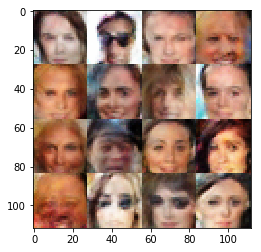

Epoch 2/2... Discriminator Loss: 1.1493... Generator Loss: 0.9334
Epoch 2/2... Discriminator Loss: 1.2931... Generator Loss: 0.9784
Epoch 2/2... Discriminator Loss: 1.2124... Generator Loss: 1.0030
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 1.3389... Generator Loss: 0.7833
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 1.1914
Epoch 2/2... Discriminator Loss: 0.9117... Generator Loss: 1.0636
Epoch 2/2... Discriminator Loss: 1.1867... Generator Loss: 0.7657
Epoch 2/2... Discriminator Loss: 0.9268... Generator Loss: 1.1386
Epoch 2/2... Discriminator Loss: 1.1132... Generator Loss: 1.0553


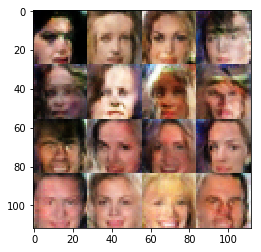

Epoch 2/2... Discriminator Loss: 0.9830... Generator Loss: 0.9774
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 0.7357
Epoch 2/2... Discriminator Loss: 1.2337... Generator Loss: 1.0882
Epoch 2/2... Discriminator Loss: 1.2684... Generator Loss: 0.9233
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 1.3049
Epoch 2/2... Discriminator Loss: 1.0666... Generator Loss: 1.0820
Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 1.0055
Epoch 2/2... Discriminator Loss: 1.3274... Generator Loss: 0.9955
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 0.9493
Epoch 2/2... Discriminator Loss: 1.1129... Generator Loss: 0.7180


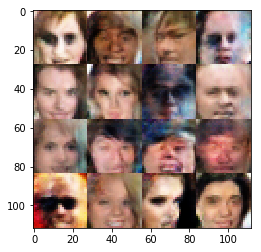

Epoch 2/2... Discriminator Loss: 1.3249... Generator Loss: 0.9562
Epoch 2/2... Discriminator Loss: 1.1570... Generator Loss: 0.8316
Epoch 2/2... Discriminator Loss: 1.1803... Generator Loss: 1.1663
Epoch 2/2... Discriminator Loss: 1.3138... Generator Loss: 1.2352
Epoch 2/2... Discriminator Loss: 0.9262... Generator Loss: 1.0194
Epoch 2/2... Discriminator Loss: 1.3665... Generator Loss: 0.8678
Epoch 2/2... Discriminator Loss: 1.0047... Generator Loss: 1.1130
Epoch 2/2... Discriminator Loss: 1.0992... Generator Loss: 1.1266
Epoch 2/2... Discriminator Loss: 1.2644... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 1.3723... Generator Loss: 1.2887


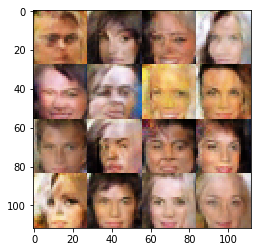

Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 1.1377
Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 1.2449
Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 0.9358
Epoch 2/2... Discriminator Loss: 1.2511... Generator Loss: 1.0492
Epoch 2/2... Discriminator Loss: 1.1516... Generator Loss: 1.0001
Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 1.0383
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.1573
Epoch 2/2... Discriminator Loss: 1.1447... Generator Loss: 0.8693
Epoch 2/2... Discriminator Loss: 0.9951... Generator Loss: 1.0582
Epoch 2/2... Discriminator Loss: 1.1308... Generator Loss: 1.0632


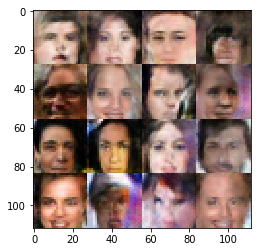

Epoch 2/2... Discriminator Loss: 1.1885... Generator Loss: 1.0295
Epoch 2/2... Discriminator Loss: 0.9336... Generator Loss: 1.2276
Epoch 2/2... Discriminator Loss: 1.3032... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 1.2700... Generator Loss: 1.3393
Epoch 2/2... Discriminator Loss: 1.2069... Generator Loss: 0.8692
Epoch 2/2... Discriminator Loss: 1.1585... Generator Loss: 0.9538
Epoch 2/2... Discriminator Loss: 1.1949... Generator Loss: 0.9106
Epoch 2/2... Discriminator Loss: 1.1369... Generator Loss: 0.9961
Epoch 2/2... Discriminator Loss: 0.9228... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 1.0029... Generator Loss: 1.2145


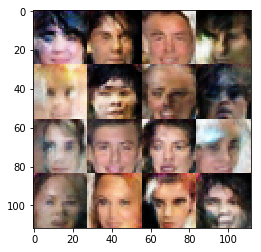

Epoch 2/2... Discriminator Loss: 1.1799... Generator Loss: 0.9303
Epoch 2/2... Discriminator Loss: 1.1456... Generator Loss: 1.0087
Epoch 2/2... Discriminator Loss: 1.2985... Generator Loss: 1.0033
Epoch 2/2... Discriminator Loss: 1.1161... Generator Loss: 0.8778
Epoch 2/2... Discriminator Loss: 1.1729... Generator Loss: 0.9363
Epoch 2/2... Discriminator Loss: 1.3093... Generator Loss: 0.6901
Epoch 2/2... Discriminator Loss: 1.1817... Generator Loss: 0.7331
Epoch 2/2... Discriminator Loss: 1.1936... Generator Loss: 0.8216
Epoch 2/2... Discriminator Loss: 1.3784... Generator Loss: 0.9788
Epoch 2/2... Discriminator Loss: 0.9654... Generator Loss: 1.1178


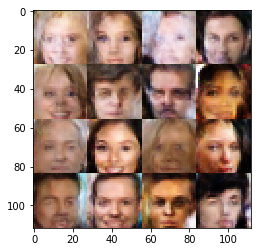

Epoch 2/2... Discriminator Loss: 0.9924... Generator Loss: 1.1440
Epoch 2/2... Discriminator Loss: 1.3463... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 1.2363... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 1.2583
Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 0.8653
Epoch 2/2... Discriminator Loss: 0.8889... Generator Loss: 1.1379
Epoch 2/2... Discriminator Loss: 1.3997... Generator Loss: 0.8455
Epoch 2/2... Discriminator Loss: 1.3983... Generator Loss: 0.7424
Epoch 2/2... Discriminator Loss: 1.3157... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.2468... Generator Loss: 0.9201


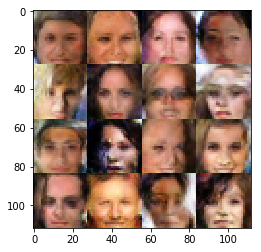

Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 1.0281
Epoch 2/2... Discriminator Loss: 1.0539... Generator Loss: 1.0547
Epoch 2/2... Discriminator Loss: 1.2815... Generator Loss: 0.9681
Epoch 2/2... Discriminator Loss: 1.2373... Generator Loss: 0.9301
Epoch 2/2... Discriminator Loss: 1.2018... Generator Loss: 1.0807
Epoch 2/2... Discriminator Loss: 1.1904... Generator Loss: 1.3579
Epoch 2/2... Discriminator Loss: 1.1883... Generator Loss: 0.8354
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 1.1140
Epoch 2/2... Discriminator Loss: 1.6038... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 1.0634... Generator Loss: 1.0096


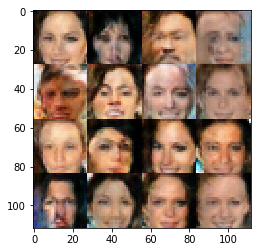

Epoch 2/2... Discriminator Loss: 1.1601... Generator Loss: 0.8443
Epoch 2/2... Discriminator Loss: 1.3114... Generator Loss: 1.1089
Epoch 2/2... Discriminator Loss: 1.1872... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.9192
Epoch 2/2... Discriminator Loss: 1.1708... Generator Loss: 0.9425
Epoch 2/2... Discriminator Loss: 1.3022... Generator Loss: 0.7935
Epoch 2/2... Discriminator Loss: 1.1318... Generator Loss: 1.1306
Epoch 2/2... Discriminator Loss: 0.9929... Generator Loss: 1.6137
Epoch 2/2... Discriminator Loss: 1.2920... Generator Loss: 0.7174
Epoch 2/2... Discriminator Loss: 0.8906... Generator Loss: 1.2960


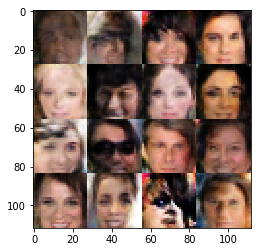

Epoch 2/2... Discriminator Loss: 1.2623... Generator Loss: 0.9748
Epoch 2/2... Discriminator Loss: 1.2418... Generator Loss: 1.1472
Epoch 2/2... Discriminator Loss: 1.2010... Generator Loss: 1.2408
Epoch 2/2... Discriminator Loss: 1.0847... Generator Loss: 1.0335
Epoch 2/2... Discriminator Loss: 1.3707... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 1.0390... Generator Loss: 0.8525
Epoch 2/2... Discriminator Loss: 1.3232... Generator Loss: 0.9850
Epoch 2/2... Discriminator Loss: 1.3591... Generator Loss: 0.9810
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.8285
Epoch 2/2... Discriminator Loss: 1.3994... Generator Loss: 0.7480


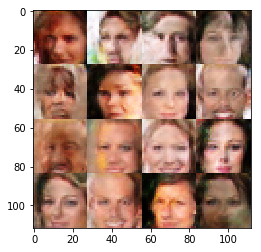

Epoch 2/2... Discriminator Loss: 1.0200... Generator Loss: 1.1360
Epoch 2/2... Discriminator Loss: 1.0455... Generator Loss: 1.0392
Epoch 2/2... Discriminator Loss: 1.1078... Generator Loss: 1.0426
Epoch 2/2... Discriminator Loss: 1.1162... Generator Loss: 0.9653
Epoch 2/2... Discriminator Loss: 1.0989... Generator Loss: 0.7691
Epoch 2/2... Discriminator Loss: 1.2306... Generator Loss: 0.7968
Epoch 2/2... Discriminator Loss: 1.0833... Generator Loss: 1.1411
Epoch 2/2... Discriminator Loss: 1.0827... Generator Loss: 1.1188
Epoch 2/2... Discriminator Loss: 1.3581... Generator Loss: 1.1098
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 1.1261


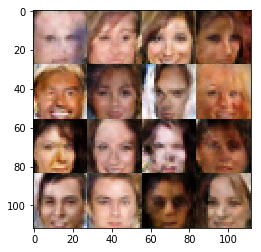

Epoch 2/2... Discriminator Loss: 1.2081... Generator Loss: 0.9818
Epoch 2/2... Discriminator Loss: 1.2681... Generator Loss: 1.1655
Epoch 2/2... Discriminator Loss: 1.2417... Generator Loss: 1.1086
Epoch 2/2... Discriminator Loss: 1.2176... Generator Loss: 0.7850
Epoch 2/2... Discriminator Loss: 0.9510... Generator Loss: 1.1188
Epoch 2/2... Discriminator Loss: 1.0476... Generator Loss: 0.9259
Epoch 2/2... Discriminator Loss: 0.9114... Generator Loss: 1.4946
Epoch 2/2... Discriminator Loss: 1.1392... Generator Loss: 1.1092
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 1.4823
Epoch 2/2... Discriminator Loss: 1.2567... Generator Loss: 0.9374


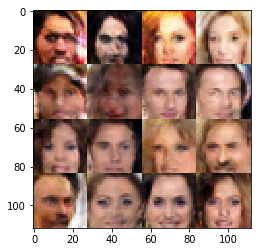

Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 1.0537
Epoch 2/2... Discriminator Loss: 1.0028... Generator Loss: 1.5570
Epoch 2/2... Discriminator Loss: 1.3062... Generator Loss: 0.9117
Epoch 2/2... Discriminator Loss: 1.2811... Generator Loss: 0.7759
Epoch 2/2... Discriminator Loss: 1.1706... Generator Loss: 1.2736
Epoch 2/2... Discriminator Loss: 1.2090... Generator Loss: 0.7763
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.9343
Epoch 2/2... Discriminator Loss: 1.1273... Generator Loss: 1.4898
Epoch 2/2... Discriminator Loss: 1.1861... Generator Loss: 0.8714
Epoch 2/2... Discriminator Loss: 0.9923... Generator Loss: 1.1227


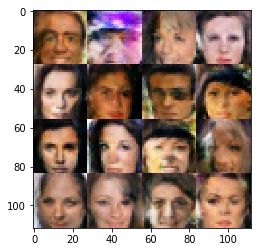

Epoch 2/2... Discriminator Loss: 1.1811... Generator Loss: 1.1665
Epoch 2/2... Discriminator Loss: 1.5408... Generator Loss: 0.7988
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.9049
Epoch 2/2... Discriminator Loss: 1.0380... Generator Loss: 0.9459
Epoch 2/2... Discriminator Loss: 1.0041... Generator Loss: 1.1792
Epoch 2/2... Discriminator Loss: 1.2470... Generator Loss: 0.7924
Epoch 2/2... Discriminator Loss: 1.2291... Generator Loss: 1.3607
Epoch 2/2... Discriminator Loss: 1.3479... Generator Loss: 0.8473
Epoch 2/2... Discriminator Loss: 1.1542... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.1412... Generator Loss: 1.0655


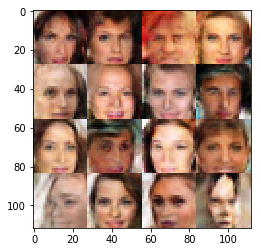

Epoch 2/2... Discriminator Loss: 1.0727... Generator Loss: 0.9980
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 1.0828
Epoch 2/2... Discriminator Loss: 1.2297... Generator Loss: 0.7766
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 0.9557
Epoch 2/2... Discriminator Loss: 1.2434... Generator Loss: 0.8744
Epoch 2/2... Discriminator Loss: 1.1183... Generator Loss: 0.9692
Epoch 2/2... Discriminator Loss: 1.0900... Generator Loss: 0.9109
Epoch 2/2... Discriminator Loss: 1.2126... Generator Loss: 1.0916
Epoch 2/2... Discriminator Loss: 1.1555... Generator Loss: 1.1110
Epoch 2/2... Discriminator Loss: 0.8840... Generator Loss: 0.9676


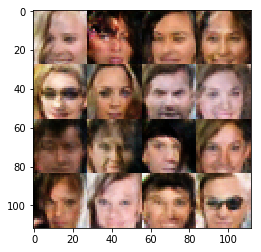

Epoch 2/2... Discriminator Loss: 1.2187... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 0.9001... Generator Loss: 1.1080
Epoch 2/2... Discriminator Loss: 1.2456... Generator Loss: 0.7716
Epoch 2/2... Discriminator Loss: 1.1470... Generator Loss: 1.0838
Epoch 2/2... Discriminator Loss: 1.1899... Generator Loss: 0.7217
Epoch 2/2... Discriminator Loss: 1.0479... Generator Loss: 0.9168
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 1.0480... Generator Loss: 1.1270
Epoch 2/2... Discriminator Loss: 1.3745... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.3804... Generator Loss: 0.7011


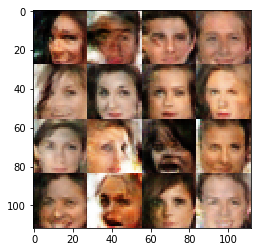

Epoch 2/2... Discriminator Loss: 1.0579... Generator Loss: 1.0305
Epoch 2/2... Discriminator Loss: 1.0988... Generator Loss: 0.8379
Epoch 2/2... Discriminator Loss: 1.3436... Generator Loss: 1.0821
Epoch 2/2... Discriminator Loss: 1.0629... Generator Loss: 0.9757
Epoch 2/2... Discriminator Loss: 1.1521... Generator Loss: 0.8469
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.0937... Generator Loss: 0.8300
Epoch 2/2... Discriminator Loss: 1.2333... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 1.3351... Generator Loss: 0.8175


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。